In [1]:
import os
import sys

In [2]:
working_dir = os.path.abspath('..')

%cd ../../saga
sagadir = !pwd
sagadir = sagadir[0]
!python setup.py build
%cd $working_dir

/Users/erik/projects/saga/saga
running build
running build_py
/Users/erik/projects/saga/erik


In [3]:
sagalibdir = os.path.join(sagadir, 'build/lib')
print('Adding', sagalibdir, 'to the python path')
sys.path.insert(0, sagalibdir)

import SAGA as saga
from SAGA import ObjectCuts as ocuts

Adding /Users/erik/projects/saga/saga/build/lib to the python path


In [4]:
from __future__ import print_function, division

import datetime
import collections
from urllib.request import urlopen

import tqdm

import numpy as np

from scipy import interpolate

from IPython.display import HTML

import bs4 

import hosts
import targeting

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist
from astropy.io import fits
from astropy import convolution
from astropy import modeling
from astropy.time import Time

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)

In [6]:
def add_coord_to_tab(tab, raname='RA', decname='Dec', unit=u.deg, coocolname='coord'):
    coo = SkyCoord(ra=tab[raname], dec=tab[decname], unit=unit, frame='icrs')
    tab[coocolname] = coo
    return coo

In [7]:
imagelist_kwargs={}
# this supresses actually showing the imagelists - comment it out to get the imagelists to pop up
imagelist_kwargs['url'] = None

# Load the SAGA datasets 

In [8]:
saga_database = saga.Database(os.path.join(os.environ['HOME'],'Dropbox/SAGA/'), working_dir)
saga_host_catalog = saga.HostCatalog(saga_database)
saga_object_catalog = saga.ObjectCatalog(saga_database)

## First load the flag0/host lists

In [9]:
tab_hosts = saga_host_catalog.load()
tab_hosts

HOSTID,SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,decals_dr7,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
str9,str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,object
nsa126115,Bandamanna,126115,0.995575,20.7524,279,613769,7817,19,2309.0,32.4741,12.5605,12.1093,11.7516,10.65,8.4,0.015,0,-24.1577,-19.9972,-40.7605,14.1617,--,0.975929,0.995575,20.7524,NGC_7817,2309.0,-1,32.4741,0.610269,14.2853,0.00949019,0.246425,-18.5575,12.8044,0.000935407,0.192013,-19.9616,11.9377,0.000573401,0.132833,-20.7677,11.4279,0.000569579,0.0987095,-21.2398,11.0222,0.00146553,0.0734218,-21.6198,9.489,0.006,0.0412162,-23.1108,8.734,0.007,0.0261016,-23.8533,8.421,0.008,0.0175561,-24.1403,12700000000,0.60785,-24.1577,0.0,0.0,0.0,0.9906054139,"0.995575,20.7524"
pgc1952,--,-1,8.0088,-64.2534,1952,-1,-1,-1,2704.0,39.2829,--,--,--,11.46,9.01,0.022,48,-23.961,--,-52.7437,20.145,12.03,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.961,0.9885177612,0.0,0.0,0.0,"8.0088,-64.2534"
pgc2052,--,-1,8.56455,-27.8037,2052,-1,150,-1,1583.0,22.9306,--,--,--,10.29,8.506,0.02,48,-23.2961,--,-86.13,7.30434,12.136,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.2961,1.0,0.0,0.0,0.0,"8.56455,-27.8037"
nsa127226,--,127226,8.69484,-8.39644,2081,614858,157,-1,1652.0,21.7302,11.1688,10.8702,10.6678,9.52,7.665,0.023,0,-24.0203,-20.5165,-70.8577,10.4411,13.824,0.98665,8.69484,-8.39644,g0034468-082347,1652.0,-1,21.7302,0.22631,12.3931,0.00512135,0.188557,-19.4944,11.1273,0.000244748,0.146923,-20.7131,10.496,0.00020272,0.10164,-21.2952,10.1498,0.000549536,0.0755297,-21.6147,9.90718,0.000947486,0.0561802,-21.8373,8.6,0.006,0.0315374,-23.1154,7.922,0.008,0.0199722,-23.7829,7.681,0.012,0.0134334,-24.0066,17700000000,0.677666,-24.0203,0.02085505798,0.06986444443,0.0,0.9801877141,"8.69484,-8.39644"
pgc2437,--,-1,10.146,-13.8728,2437,-1,210,-1,1634.0,23.6725,--,--,--,--,8.379,0.017,48,-23.4922,--,-76.5045,10.3761,10.368,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.4922,0.0,0.0,0.0,0.434060216,"10.146,-13.8728"
pgc2778,--,-1,11.8665,-31.4221,2778,-1,254,-1,1629.0,23.5998,--,--,--,10.23,8.72,0.025,48,-23.1445,--,-85.6198,7.93676,--,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.1445,1.0,0.0,0.0,0.0,"11.8665,-31.4221"
pgc3089,--,-1,13.1765,-31.2058,3089,-1,289,-1,1630.0,23.6143,--,--,--,--,7.99,0.018,48,-23.8759,--,-85.9132,8.23853,13.677,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.8759,1.0,0.0,0.0,0.0,"13.1765,-31.2058"
pgc3743,--,-1,15.7143,-65.61,3743,-1,360,-1,2299.0,33.3642,--,--,--,11.46,9.029,0.023,48,-23.5874,--,-51.4764,17.0111,--,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.5874,0.3179916441,

### Identify already-observed hosts as paper 1 + aat18 + mmt18 

In [10]:
list(saga_host_catalog._predefined_queries)

['all',
 'paper1',
 'paper1_complete',
 'paper1_incomplete',
 'mmt_2018a',
 'mmt_2018b',
 'mmt_2019a',
 'aat_2018a_has_sdss',
 'aat_2018a_des_only',
 'aat_2018a',
 'aat_2018b',
 'no_flags',
 'flag0',
 'has_sdss',
 'has_nsa',
 'has_deeper_imaging',
 'has_decam',
 'has_des',
 'has_des_dr1',
 'has_decals',
 'has_decals_nsa',
 'has_decals_dr5',
 'has_decals_dr6',
 'has_decals_dr7',
 'good']

In [11]:
def combine_dedup_catalogs(nma, nmb):
    if isinstance(nma, str):
        cata = saga_host_catalog.load(nma)
    else:
        cata = nma
    catb = saga_host_catalog.load(nmb)

    del cata['coord'], catb['coord']

    catboth = table.vstack([cata, catb])
    add_coord_to_tab(catboth)
    return catboth[np.unique(catboth['HOSTID'], return_index=True)[-1]]

In [12]:
p1tab = saga_host_catalog.load('paper1')

mmt18 = combine_dedup_catalogs('mmt_2018a', 'mmt_2018b')
mmt18 = combine_dedup_catalogs(mmt18, 'mmt_2019a')
mmt18_observed_nsaids = [144953, 69028, 165707, 52773, 165082, 161174, 163956, 147606, 165980, #a
                         149977, 149781, 150887, 132339, 126115, 129387,  #18b
                         16235, 16559, 160302]   #19a
msk = []
for row in mmt18:
    if row['NSAID'] in mmt18_observed_nsaids:
        mmt18_observed_nsaids.pop(mmt18_observed_nsaids.index(row['NSAID']))
        msk.append(True)
    else:
        msk.append(False)
msk = np.array(msk)
assert len(mmt18_observed_nsaids) == 0
mmt18 = mmt18[msk]
mmt18['SAGA_name'] = ['mmt18_{}'.format(i) for i in range(len(mmt18))]


#aat18 = combine_dedup_catalogs('aat_2018a', 'aat_2018b')
aat18 = saga_host_catalog.load('aat_2018a')
aat18_observed = [#'NSA13927', #missing?
 'NSA141465',
 'NSA145729',
 'NSA145879',
 'NSA3469',
 'PGC2052',
 'PGC64427',
 'PGC66318',
 'PGC66934',
 'PGC67146',
 'PGC67663',
 'PGC67817',
 'PGC70094',
    ] # b was a wash


nsalst = list(aat18['NSAID'])
pgclst = list(aat18['PGC'])
msk = np.zeros(len(aat18), dtype=bool)
found = []
for obs in aat18_observed:
    idx = None
    if obs.startswith('NSA'):
        idx = nsalst.index(int(obs[3:]))
    elif obs.startswith('PGC'):
        idx = pgclst.index(int(obs[3:]))
    else:
        assert False
    if idx is not None:
        found.append(True)
        msk[idx] = True

aat18 = aat18[msk]
aat18['SAGA_name'] = ['aat18_{}'.format(i) for i in range(len(aat18))]
assert len(aat18_observed) == np.sum(msk)

missing_aat18 = saga_host_catalog.load('NSA13927')
missing_aat18['SAGA_name'][:] = 'aat18_m'
# the "missing" one is Sopranos!

tabs = [p1tab, mmt18, aat18]#, missing_aat18]

In [13]:
# combine the tables derived above
for t in tabs:
    del t['coord']
tab_hosts_obs = table.vstack(tabs)
tab_hosts_obs

HOSTID,SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,decals_dr7
str9,str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
nsa126115,Bandamanna,126115,0.995575,20.7524,279,613769,7817,19,2309.0,32.4741,12.5605,12.1093,11.7516,10.65,8.4,0.015,0,-24.1577,-19.9972,-40.7605,14.1617,--,0.975929,0.995575,20.7524,NGC_7817,2309.0,-1,32.4741,0.610269,14.2853,0.00949019,0.246425,-18.5575,12.8044,0.000935407,0.192013,-19.9616,11.9377,0.000573401,0.132833,-20.7677,11.4279,0.000569579,0.0987095,-21.2398,11.0222,0.00146553,0.0734218,-21.6198,9.489,0.006,0.0412162,-23.1108,8.734,0.007,0.0261016,-23.8533,8.421,0.008,0.0175561,-24.1403,12700000000,0.60785,-24.1577,0.0,0.0,0.0,0.9906054139
nsa129237,HarryPotter,129237,20.449,17.5922,4948,642806,-1,903,2518.0,38.6531,13.6794,13.1688,12.7204,12.24,9.38,0.021,0,-23.5559,-19.2566,-44.6775,14.5037,--,0.986166,20.449,17.5922,UGC_00903,2518.0,-1,38.6531,0.860315,15.8055,0.0108988,0.421174,-17.5881,14.228,0.0012925,0.328176,-19.0608,13.1764,0.000897049,0.227031,-20.0051,12.5798,0.00090996,0.168708,-20.5398,12.0575,0.00156547,0.125488,-21.0174,10.802,0.022,0.070444,-22.2057,9.856,0.012,0.0446112,-23.1288,9.415,0.021,0.0300058,-23.5358,7440000000,1.24149,-23.5559,0.0,0.0,0.0,1.0
nsa132339,Narnia,132339,39.5482,-1.31876,9988,619846,1015,2124,2629.0,37.155,12.5487,12.2488,11.9976,11.06,9.334,0.035,0,-23.5161,-20.3014,-53.6539,16.4536,14.178,0.983103,39.5482,-1.31876,g0238116-011907,2629.0,-1,37.155,0.515757,14.474,0.00614933,0.135011,-18.5375,12.717,0.00146005,0.105199,-20.2622,11.8516,0.00109992,0.0727765,-21.0796,11.5123,0.00123966,0.0540807,-21.4,11.2265,0.00173407,0.0402261,-21.6686,10.347,0.02,0.0225814,-22.5216,9.671,0.024,0.0143005,-23.1918,9.345,0.032,0.0096186,-23.4956,18200000000,5.43756,-23.5161,1.0,1.0,0.0,1.0
nsa33446,StarTrek,33446,123.241,36.2546,23028,162578,2543,4273,2469.7,37.7379,12.3668,12.0137,11.739,11.77,9.407,0.032,0,-23.4769,-20.5171,31.306,14.5285,12.875,0.972509,123.241,36.2546,08125792+3615166,2469.7,-1,37.7379,0.587718,14.0444,0.00464789,0.291001,-19.1532,12.5692,0.000890168,0.226746,-20.5611,11.7713,0.00338937,0.156862,-21.2786,11.3544,0.00105029,0.116565,-21.6548,11.0233,0.00128046,0.086703,-21.9537,10.532,0.023,0.0486717,-22.3985,9.745,0.026,0.0308231,-23.1702,9.431,0.03,0.0207318,-23.4569,21200000000,2.13367,-23.4769,0.0,0.0,1.0,0.0
nsa85746,MobyDick,85746,149.588,32.3699,28805,413265,3067,5351,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,--,0.978734,149.588,32.3699,09582107+3222116,1451.33,-1,25.1343,0.401621,13.8392,0.00354317,0.0627641,-18.2411,12.514,0.000537367,0.0489054,-19.5442,11.7926,0.00051166,0.0338325,-20.2479,11.4313,0.000435475,0.0251412,-20.5994,11.1085,0.00110246,0.0187004,-20.9154,9.886,0.011,0.0104977,-22.1253,9.156,0.015,0.00664805,-22.8525,8.904,0.015,0.00447152,-23.0925,7680000000,0.932093,-23.1023,0.0,0.8620689511,0.7513061762,1.0
nsa137625,Oz,137625,158.231,28.5118,31166,624873,3277,5731,1408.0,24.4117,11.9393,11.5812,11.3468,--,8.917,0.018,0,-23.021,-19.9987,59.4484,5.67327,10.431,0.982474,158.231,28.5118,NGC_3277,1408.0,-1,24.4117,0.265102,13.6891,0.0035176,0.

# Now collect Jason T's QSO datasets 

In [14]:
tab_qso = table.Table(table.Table.read('catalogs/dr7qso_galex.fits'), masked=True)
add_coord_to_tab(tab_qso, raname='RA', decname='DEC')

tab_qso19 = tab_qso[(0<tab_qso['FUV_MAG'])&(tab_qso['FUV_MAG']<19)]

print(len(tab_qso), len(tab_qso19))
tab_qso19

105811 2627


SDSSNAME,RA,DEC,Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,A_U,LOGNHI,FIRSTMAG,FIRST_SN,FIRST_SEP,LG_RASS_RATE,RASS_SN,RASS_SEP,TWOMASSMAG_J,TWOMASSMAGERR_J,TWOMASSMAG_H,TWOMASSMAGERR_H,TWOMASSMAG_K,TWOMASSMAGERR_K,TWOMASS_SEP,M_I,DELTA_G_I,MORPHOLOGY,SCIENCEPRIMARY,MODE,UNIFORM,BESTPRIMTARGET,TS_B_QSO,TS_B_HIZ,TS_B_FIRST,TS_B_ROSAT,TS_B_SERENDIP,TS_B_STAR,TS_B_GAL,RUN_BEST,MJD_BEST,MJD_SPEC,PLATE,FIBERID,RERUN_BEST,CAMCOL_BEST,FIELD_BEST,OBJ_BEST,TARGPRIMTARGET,TS_T_QSO,TS_T_HIZ,TS_T_FIRST,TS_T_ROSAT,TS_T_SERENDIP,TS_T_STAR,TS_T_GAL,T_PSFMAG_U,T_PSFMAGERR_U,T_PSFMAG_G,T_PSFMAGERR_G,T_PSFMAG_R,T_PSFMAGERR_R,T_PSFMAG_I,T_PSFMAGERR_I,T_PSFMAG_Z,T_PSFMAGERR_Z,BESTOBJID,SPECOBJID,OBJECT_NAME,GALEX_OBJID,GALEX_RA,GALEX_DEC,GALEX_SEP,GALEX_TYPE,GALEX_BAND,NUV_FLUX,NUV_FLUXERR,FUV_FLUX,FUV_FLUXERR,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,GALEX_NOBJ,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
bytes18,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,bytes12,int16,int16,int16,int16,int16,int16,int16,int16,int32,int32,int16,int16,int16,int16,int16,int16,bytes12,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes21,bytes21,bytes25,int64,float64,float64,float64,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,int16,object
000011.96+000225.3,0.04983900114893913,0.04036499932408333,0.4789,18.228,0.027,17.934,0.02,17.995,0.019,17.934,0.014,17.873,0.029,0.161,20.502,0.0,0.0,0.0,-1.66,2.157,2.04,16.651,0.136,15.82,0.149,14.821,0.111,0.209,-24.068,-0.146,0,1,1,0,134224898,1,0,0,1,0,0,0,3325,52522,51791,387,200,41,4,108,19,134224900,1,0,0,1,0,0,0,17.835,0.011,17.58,0.004,17.695,0.005,17.646,0.006,17.66,0.024,588015509269381139,109153257477111808,LBQS 2357-0014,6381013764764861047,0.04982507636213442,0.04048678564380311,0.4412872784416751,1,3,198.5861,9.1663,134.93611,12.721326,18.15272,0.050127383,18.577576,0.10238445,2,"0.04983900114893913,0.04036499932408333"
000110.97-105247.4,0.29572200775146484,-10.879857063293457,0.5282,17.999,0.022,17.674,0.026,17.646,0.016,17.484,0.024,17.512,0.028,0.183,20.439,0.0,0.0,0.0,-9.0,0.0,0.0,16.467,0.095,15.614,0.112,14.916,0.108,0.155,-24.764,0.017,0,1,1,0,1048578,1,0,0,0,1,0,0,1740,51814,52143,650,126,40,1,24,71,1048580,1,0,0,0,1,0,0,17.95,0.018,17.65,0.018,17.658,0.018,17.506,0.018,17.501,0.021,587727225153388615,183182687870124032,SDSS J000110.97-105247.4,2435007175675876212,0.295777766875642,-10.8798445585674,0.20219960592011493,0,3,226.309,2.69221,141.979,3.5783,18.0108,0.0129192,18.5223,0.0273704,2,"0.29572200775146484,-10.879857063293457"
000410.80-104527.1,1.0450270175933838,-10.757536888122559,0.2397,18.125,0.025,17.951,0.02,17.681,0.027,17.531,0.013,17.432,0.021,0.192,20.444,0.0,0.0,0.0,-1.352,3.3,7.26,16.097,0.087,15.181,0.098,14.368,0.072,0.091,-22.829,-0.221,0,1,1,0,7170,1,0,0,1,0,0,0,1729,51813,52143,650,18,40,2,90,17,7172,1,0,0,1,0,0,0,18.096,0.018,17.929,0.018,17.693,0.017,17.522,0.013,17.409,0.018,587727178449944593,183182687417139200,SDSS J000410.80-104527.1,6380415564941101376,1.045146922280434,-10.75742635055539,0.5815398758216943,1,3,101.83553,6.9679437,113.50677,11.190304,18.877844,0.074307926,18.76534,0.10706559,2,"1.0450270175933838,-10.757536888122559"
000548.24-084808.4,1.4510070085525513,-8.802347183227539,1.1906,17.968,0.034,17.874,0.035,17.623,0.019,17.636,0.022,17.715,0.027,0.172,20.487,0.0,0.0,0.0,-9.0,0.0,0.0,17.126,0.259,16.657,0.296,0.0,0.0,0.019,-26.577,-0.057,0,1,1,0,2,1,0,0,0,0,0,0,1740,51814,52141,651,328,40,6,32,7,4,1,0,0,0,0,0,0,17.92,0.014,17.892,0.014,17.663,0.007,17.629,0.018,17.705,0.025,587727227838267399,183464155104149504,SDSS J00054

In [15]:
with fits.open('https://archive.stsci.edu/missions/hlsp/uvqs/hlsp_uvqs_multi_multi_all_multi_v1_redshifts.fits', 
              cache=True) as f:
    uvqs_tab = table.Table.read(f)
add_coord_to_tab(uvqs_tab, raname='RA', decname='DEC')

# JT recommended this cut
uvqs_good_tab = uvqs_tab[uvqs_tab['Z_QUAL']>=3]

print(len(uvqs_good_tab))
uvqs_good_tab

/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1121


DEC,FUV,NAME,NUV,OBJ,OBJ_IDX,OBJ_IDX2,OBSV,OBS_DATE,RA,SCI_FILE,SCND_FILE,SPEC_QUAL,THETA [20],W1,W2,Z,ZASS_FIL,Z_QUAL,Z_SIG,comment,dbx_path,instr,CAND,SPEC_FILE,FINDER,coord
deg,,,,,,,,,deg,,,,,,,,,,,,,,,,,"deg,deg"
float64,float64,str80,float64,int64,int64,int64,str80,str80,float64,str80,str80,int64,float64,float64,float64,float64,str80,int64,float64,str80,str80,str80,int64,str148,str128,object
-20.07436111111111,18.272998809814453,UVQSJ000000.15-200427.7,17.969999313354492,0,1,-1,LCO,Aug2014,0.000625,09aug2014/Science/sci-ccd0918.fits.gz,,3,4.399489402770996 .. 0.0,13.54800033569336,12.538999557495117,0.2907995879650116,LCO_09aug2014_zassess.fits,4,0.0001711066870484501,,LCO/August2014,BCS,1,UVQSJ000000.15-200427.7_LCO.fits,UVQSJ000000.15-200427.7_DSS.pdf,"0.000625,-20.07436111111111"
-39.296638888888886,17.82442855834961,UVQSJ000503.70-391747.9,17.232192993164062,0,0,-1,LCO,Aug2014,1.2654166666666666,07aug2014/Science/sci-ccd0645.fits.gz,,3,8.086631774902344 .. 0.0,12.260000228881836,11.12399959564209,0.6523942947387695,LCO_07aug2014_zassess.fits,3,0.00036326117697171867,,LCO/August2014,BCS,1,UVQSJ000503.70-391747.9_LCO.fits,UVQSJ000503.70-391747.9_DSS.pdf,"1.2654166666666666,-39.296638888888886"
-26.194583333333334,18.1590518951416,UVQSJ000609.57-261140.5,17.529890060424805,0,1,-1,LCO,Aug2014,1.539875,09aug2014/Science/sci-ccd0920.fits.gz,,3,5.216460227966309 .. 0.0,13.307999610900879,12.12399959564209,0.6484312415122986,LCO_09aug2014_zassess.fits,3,0.0002498269022908062,,LCO/August2014,BCS,1,UVQSJ000609.57-261140.5_LCO.fits,UVQSJ000609.57-261140.5_DSS.pdf,"1.539875,-26.194583333333334"
42.27961111111111,18.08545684814453,UVQSJ000717.69+421646.6,17.612794876098633,0,0,0,Lick,Jan2015,1.8237083333333333,Jan_2015/Science/sci-b337.fits.gz,Jan_2015/Science/sci-r337.fits.gz,4,17.775127410888672 .. 0.0,12.442000389099121,11.508000373840332,0.0,Lick_jan2015_zassess.fits,4,0.00022893415007274598,,Lick,Kast,1,UVQSJ000717.69+421646.6_Lick.fits,UVQSJ000717.69+421646.6_DSS.pdf,"1.8237083333333333,42.27961111111111"
-63.862722222222224,17.955339431762695,UVQSJ000741.00-635145.8,17.411048889160156,0,0,-1,LCO,Aug2014,1.9208333333333334,07aug2014/Science/sci-ccd0640.fits.gz,,3,4.412016868591309 .. 0.0,12.652999877929688,11.454000473022461,0.5593018531799316,LCO_07aug2014_zassess.fits,3,0.00040529153193347156,,LCO/August2014,BCS,1,UVQSJ000741.00-635145.8_LCO.fits,UVQSJ000741.00-635145.8_DSS.pdf,"1.9208333333333334,-63.862722222222224"
3.2925277777777775,17.80329704284668,UVQSJ000750.78+031733.1,17.008296966552734,0,1,-1,LCO,Aug2014,1.9615833333333335,06aug2014/Science/sci-ccd0564.fits.gz,,4,0.9978417754173279 .. 0.0,12.975000381469727,11.576000213623047,1.1010165214538574,LCO_06aug2014_zassess.fits,4,0.001264573773369193,,LCO/August2014,BCS,1,UVQSJ000750.78+031733.1_LCO.fits,UVQSJ000750.78+031733.1_SDSS.pdf,"1.9615833333333335,3.2925277777777775"
5.471888888888889,18.066572189331055,UVQSJ000755.67+052818.8,17.29297637939453,0,0,-1,LCO,Aug2014,1.9819583333333333,10aug2014/Science/sci-ccd1055.fits.gz,,3,7.4596848487854 .. 0.0,13.116999626159668,11.732999801635742,1.0984525680541992,LCO_10aug2014_zassess.fits,4,0.0009857744444161654,,LCO/August2014,BCS,1,UVQSJ000755.67+052818.8_LCO.fits,UVQSJ000755.67+052818.8_SDSS.pdf,"1.9819583333333333,5.471888888888889"
-23.888194444444444,18.321109771728516,UVQSJ000856.77-235317.5,16.892627716064453,0,0,-1,LCO,Aug2014,2.2365416666666667,09aug2014/Science/sci-ccd0922.fits.gz,,4,9.65181827545166 .. 0.0,13.00100040435791,11.734999656677246,0.8442435264587402,LCO_09aug2014_zassess.fits,3,0.0003965360519941896,,LCO/August2014,BCS,1,UVQSJ000856.77-235317.5_LCO.fits,UVQSJ000856.77-235317.5_DSS.pdf,"2.2365416666666667,-23.888194444444444"


# Load pre-existing COS spectra from HSLA

In [16]:
hsla_url = 'https://archive.stsci.edu/missions/hst/spectral_legacy/samples_05-15-2018_COS/QSOALS_COS_new_sample.html'
hsla_qso_tab = table.Table.read(hsla_url, format='html')

In [17]:
# saved a local copy so that it can be reused later if need be
#hsla_qso_tab.write('catalogs/hsla_qsos.ecsv', format='ascii.ecsv')

# reuse with this
#hsla_qso_tab = table.Table.read('catalogs/hsla_qsos.ecsv', format='ascii.ecsv')

In [18]:
add_coord_to_tab(hsla_qso_tab, 'RA', 'DEC')
print(len(hsla_qso_tab))

hsla_qso_tab

799


Number,Target Name,RA,DEC,Nexp,Target Description,AltName,AltClass,MAST,Median S/N,FUV M,FUV L,NUV M,NUV L,Download,coord
,,,,,,,,,,,,,,,"deg,deg"
int64,str24,float64,float64,int64,str20,str35,str8,str4,float64,str5,str5,str5,str5,str5,object
1,QSO-B1411+4414,213.451,44.0039,40,GALAXY;QSO,2XMM J141348.3+440014,Seyfert_,MAST,29.9723,--,. . .,. . .,. . .,ALL,"213.451,44.0039"
2,SDSSJ102847.00+391800.5,157.196,39.3001,5,UNIDENTIFIED;ACCRETI,[VV98] J102847.0+391758,QSO,MAST,4.27652,--,--,. . .,. . .,ALL,"157.196,39.3001"
3,RXSJ00508+3536,12.7114,35.6119,32,GALAXY;SEYFERT,2MASX J00505076+3536430,Seyfert_,MAST,17.2913,--,. . .,. . .,. . .,ALL,"12.7114,35.6119"
4,TON0133,192.751,30.4283,10,GALAXY;QSO,Ton 133,QSO,MAST,10.0304,--,--,. . .,. . .,ALL,"192.751,30.4283"
5,QSO-231145-141752,347.939,-14.2978,4,GALAXY;LYMAN ALPHA C,. . .,. . .,MAST,2.10193,. . .,--,. . .,. . .,ALL,"347.939,-14.2978"
6,QSO-B1215+303,184.467,30.1168,7,GALAXY;BL LAC;LYMAN,7C 121521.39+302340.00,BLLac,MAST,25.1706,--,. . .,. . .,. . .,ALL,"184.467,30.1168"
7,SDSSJ1137+6237,174.34,62.6187,8,GALAXY;LYMAN ALPHA C,[VV2006] J113721.7+623707,QSO,MAST,2.97699,. . .,--,. . .,. . .,ALL,"174.34,62.6187"
8,SDSSJ1614+4859,243.612,48.9997,10,GALAXY;LYMAN ALPHA C,[VV2006] J161426.8+485958,QSO,MAST,2.19425,. . .,--,. . .,. . .,ALL,"243.612,48.9997"


### Add in UVQS to tab_qso and down-select

In [19]:
subuvqs = uvqs_good_tab['NAME', 'RA', 'DEC', 'FUV', 'NUV', 'Z']
subuvqs.rename_column('NAME', 'OBJECT_NAME')
subuvqs.rename_column('FUV', 'FUV_MAG')
subuvqs.rename_column('NUV', 'NUV_MAG')
subuvqs['r'] = -np.ones(len(subuvqs), dtype=float)

subtab = tab_qso['OBJECT_NAME', 'RA', 'DEC', 'FUV_MAG', 'NUV_MAG', 'Z', 'PSFMAG_R']
subtab.rename_column('PSFMAG_R', 'r')
bothtab = table.vstack([subtab, subuvqs])
add_coord_to_tab(bothtab, decname='DEC')

tab_qsos_combined = bothtab[(0<bothtab['FUV_MAG'])&(bothtab['FUV_MAG']<19)]
tab_qsos_combined

OBJECT_NAME,RA,DEC,FUV_MAG,NUV_MAG,Z,r,coord
,deg,deg,,,,,"deg,deg"
str80,float64,float64,float64,float64,float64,float64,object
LBQS 2357-0014,0.04983900114893913,0.04036499932408333,18.57757568359375,18.152719497680664,0.4788999855518341,17.9950008392334,"0.04983900114893913,0.04036499932408333"
SDSS J000110.97-105247.4,0.29572200775146484,-10.879857063293457,18.522300720214844,18.010799407958984,0.5281999707221985,17.645999908447266,"0.29572200775146484,-10.879857063293457"
SDSS J000410.80-104527.1,1.0450270175933838,-10.757536888122559,18.76534080505371,18.877843856811523,0.23970000445842743,17.680999755859375,"1.0450270175933838,-10.757536888122559"
SDSS J000548.24-084808.4,1.4510070085525513,-8.802347183227539,18.924304962158203,18.031736373901367,1.190600037574768,17.62299919128418,"1.4510070085525513,-8.802347183227539"
LBQS 0003+0011,1.4884990453720093,0.47714298963546753,18.67307472229004,18.912330627441406,0.2596000134944916,18.40999984741211,"1.4884990453720093,0.47714298963546753"
LBQS 0004+0036,1.7917330265045166,0.8914179801940918,18.44498634338379,17.7886905670166,0.31619998812675476,17.290000915527344,"1.7917330265045166,0.8914179801940918"
LBQS 0006+0015,2.1446590423583984,0.53227698802948,18.656400680541992,18.028217315673828,0.2632000148296356,17.43199920654297,"2.1446590423583984,0.53227698802948"
SDSS J000904.54-103428.6,2.268925905227661,-10.574640274047852,18.36240005493164,18.688400268554688,0.24079999327659607,17.78499984741211,"2.268925905227661,-10.574640274047852"


In [20]:
#A quick check to make sure there aren't overlaps in the sample.  And there aren't... good?
idx, d2d, _ = tab_qsos_combined['coord'].match_to_catalog_sky(tab_qsos_combined['coord'], 2)
print(np.sum(d2d<3*u.arcmin))
#targeting.sampled_imagelist(tab_qsos_combined[d2d<5*u.arcmin], None)

2


### now populate the QSO tables with matches in the HSLA

In [21]:
def add_hsla_match(tab, hsla_sep_threshold=10*u.arcsec):
    idx, d2d, _ = tab['coord'].match_to_catalog_sky(hsla_qso_tab['coord'])
    #hsla_match_idx = -np.ones(len(idx))
    #hsla_match_idx[d2d<hsla_sep_threshold] = idx[d2d<hsla_sep_threshold]
    #tab['hsla_match_idx'] =  hsla_match_idx
    tab['hsla_match_idx'] = np.ma.masked_where(d2d>hsla_sep_threshold, idx)
    
tab_qso = table.Table(tab_qso, masked=True)
tab_qso19 = table.Table(tab_qso19, masked=True)
add_hsla_match(tab_qso)
add_hsla_match(tab_qso19)
add_hsla_match(tab_qsos_combined)

# Search MAST for post-HSLA COS observations

In [22]:
from astroquery.mast import Observations

In [23]:
hsla_release_date = Time('2018-7-1')
c27_due = Time('2019-4-5')
Observations.query_criteria_count(instrument_name=['COS/FUV', 'COS/NUV'], 
                                  t_obs_release=[hsla_release_date.mjd, c27_due.mjd])

1938

In [24]:
later_cos = Observations.query_criteria(instrument_name=['COS/FUV', 'COS/NUV'], 
                                        t_obs_release=[hsla_release_date.mjd, c27_due.mjd])

In [25]:
lc = later_cos[np.array(['QSO' in c or 'QUASAR' in c for c in later_cos['target_classification']])]
lc.rename_column('s_ra', 'RA')
lc.rename_column('s_dec', 'Dec')
add_coord_to_tab(lc)

def add_latercos_match(tab, lc_sep_threshold=10*u.arcsec):
    idx, d2d, _ = tab['coord'].match_to_catalog_sky(lc['coord'])
    tab['latercos_match_idx'] = np.ma.masked_where(d2d>lc_sep_threshold, idx) 
    
add_latercos_match(tab_qso)
add_latercos_match(tab_qso19)
add_latercos_match(tab_qsos_combined)

# X-match hosts 

In [26]:
def get_host_matches(hosttab, qsotab, rvir=300*u.kpc, hsla_sep_threshold=10*u.arcsec):
    tabs = []
    for row in hosttab:
        sc = row['coord']
        rvirsep = (rvir/(row['distance']*u.Mpc)).decompose()*u.radian
        seps = sc.separation(qsotab['coord'])
        
        subtab = qsotab[seps < rvirsep]
        subtab['qso_to_host'] = seps[seps < rvirsep]
        subtab['qso_to_host_phys'] = seps[seps < rvirsep].to(u.radian).value*(row['distance']*u.Mpc).to(u.kpc)

        tabs.append(subtab)
    return tabs

In [27]:
host_matches = get_host_matches(tab_hosts, tab_qso)
host_matches19 = get_host_matches(tab_hosts, tab_qso19)

n19 = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<19)) for match in host_matches]
n185 = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<18.5)) for match in host_matches]
n18 = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<18)) for match in host_matches]

tab_hosts['n_qso_fuv_lt_19'] = n19
tab_hosts['n_qso_fuv_lt_18.5'] = n185
tab_hosts['n_qso_fuv_lt_18'] = n18

In [28]:
host_matches_combined = get_host_matches(tab_hosts, tab_qsos_combined)

n19_combined = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<19)) for match in host_matches_combined]
n185_combined = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<18.5)) for match in host_matches_combined]
n18_combined = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<18)) for match in host_matches_combined]

tab_hosts['n_combined_fuv_lt_19'] = n19_combined
tab_hosts['n_combined_fuv_lt_18.5'] = n185_combined
tab_hosts['n_combined_fuv_lt_18'] = n18_combined

In [29]:
matches_to_stack = []
for host, matches in zip(tab_hosts, host_matches_combined):
    if len(matches)>0:
        matches = matches.copy()
        del matches['coord']
        matches['SAGA_name'] = str(host['SAGA_name'])
        matches['SAGA_NSAID'] = host['NSAID']
        matches['SAGA_PGC'] = host['PGC']
        matches_to_stack.append(matches)
matched_qsos = table.vstack(matches_to_stack)
matched_qsos.sort('FUV_MAG')

add_coord_to_tab(matched_qsos, 'RA', 'DEC')
#matched_qsos is used below in the planning
matched_qsos

OBJECT_NAME,RA,DEC,FUV_MAG,NUV_MAG,Z,r,hsla_match_idx,latercos_match_idx,qso_to_host,qso_to_host_phys,SAGA_name,SAGA_NSAID,SAGA_PGC,coord
,deg,deg,,,,,,,deg,kpc,,,,"deg,deg"
str80,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str8,int64,int64,object
UVQSJ023437.83-084716.0,38.657624999999996,-8.787777777777778,15.094728469848633,14.887340545654297,0.043058764189481735,-1.0,287,--,0.6043853904367612,216.1707181833966,--,132278,9843,"38.657624999999996,-8.787777777777778"
UVQSJ110852.95-233811.4,167.22062499999998,-23.636499999999998,16.319595336914062,15.888631820678711,0.08200415968894958,-1.0,--,--,0.24699356583801063,130.05320029466353,--,-1,33860,"167.22062499999998,-23.636499999999998"
SDSS J114758.59+271459.3,176.994140625,27.249813079833984,16.873571395874023,16.63808822631836,0.3626999855041504,16.118000030517578,--,--,0.3474969494732376,171.4996475038109,--,140301,36914,"176.994140625,27.249813079833984"
FBQS J095820.9+322402,149.58726501464844,32.4006233215332,17.137916564941406,16.465614318847656,0.5306000113487244,16.020999908447266,--,--,0.030729590254148807,13.480342651564731,MobyDick,85746,28805,"149.58726501464844,32.4006233215332"
SDSS J095914.85+320357.2,149.81187438964844,32.06591033935547,17.528425216674805,16.99718475341797,0.5638999938964844,16.992000579833984,35,--,0.3581665444819515,157.11917100136895,MobyDick,85746,28805,"149.81187438964844,32.06591033935547"
SDSS J120233.08+022559.7,180.6378631591797,2.4332659244537354,17.655315399169922,17.676992416381836,0.27300000190734863,17.270000457763672,--,--,0.4580539247957969,235.97350803693132,Sopranos,13927,38031,"180.6378631591797,2.4332659244537354"
SDSS J092542.32+344108.6,141.42637634277344,34.68572998046875,17.788286209106445,16.947559356689453,1.0666999816894531,16.325000762939453,705,--,0.335214067900937,161.89399354268386,--,135879,26649,"141.42637634277344,34.68572998046875"
2MASX J12022678-0129155,180.6114959716797,-1.487576961517334,17.832124710083008,17.52016258239746,0.15039999783039093,17.131000518798828,--,--,0.6431924808082065,260.9858728800687,Alice,140594,37845,"180.6114959716797,-1.487576961517334"


In [30]:
np.sum(~matched_qsos['hsla_match_idx'].mask)

7

In [31]:
np.sum(~matched_qsos['latercos_match_idx'].mask)

0

In [32]:
# A quick look at all of them

temp = tab_hosts.copy()
del temp['coord']
temp.sort('n_combined_fuv_lt_19')
temp.reverse()
temp[temp['n_combined_fuv_lt_19']>0].show_in_notebook(-1)

idx,HOSTID,SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,decals_dr7,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_combined_fuv_lt_19,n_combined_fuv_lt_18.5,n_combined_fuv_lt_18
0,nsa85746,MobyDick,85746,149.588,32.3699,28805,413265,3067,5351,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,--,0.978734,149.588,32.3699,09582107+3222116,1451.33,-1,25.1343,0.401621,13.8392,0.00354317,0.0627641,-18.2411,12.514,0.000537367,0.0489054,-19.5442,11.7926,0.00051166,0.0338325,-20.2479,11.4313,0.000435475,0.0251412,-20.5994,11.1085,0.00110246,0.0187004,-20.9154,9.886,0.011,0.0104977,-22.1253,9.156,0.015,0.00664805,-22.8525,8.904,0.015,0.00447152,-23.0925,7680000000,0.932093,-23.1023,0.0,0.8620689511,0.7513061762,1.0,3,2,2,3,2,2
1,nsa132278,--,132278,38.8656,-9.3562,9843,53158,988,-1,1510.0,20.493,11.7035,11.2789,11.4256,7.03,6.99,0.006,32,-24.568,-19.8545,-59.6963,8.12763,--,0.506566,38.8656,-9.3562,g0235277-092122,1510.0,-1,20.493,0.71954,12.3913,0.00746019,0.114519,-19.3035,11.3647,0.00256455,0.0892326,-20.2996,10.9815,0.00237625,0.0617307,-20.6502,10.5209,0.00161676,0.0458725,-21.0923,10.639,0.072169,0.0341207,-20.9616,7.336,0.001,0.0191541,-24.2426,7.351,0.002,0.01213,-24.2213,7.0,0.003,0.00815872,-24.5574,6800000000,0.557528,-24.568,1.0,1.0,0.0,1.0,2,0,0,3,1,1
2,pgc71548,--,-1,352.181,-41.3334,71548,-1,-1,-1,1503.0,21.7672,--,--,--,11.31,8.357,0.02,48,-23.332,--,-67.876,3.21727,--,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.332,1.0,0.0,0.0,0.0,0,0,0,2,2,0
3,nsa165082,--,165082,217.418,3.23331,51787,681573,5638,9308,1622.0,24.9139,11.7737,11.3893,11.1075,--,8.241,0.022,0,-23.7412,-20.2085,56.502,5.16472,10.063,0.973196,217.418,3.23331,NGC_5638,1622.0,-1,24.9139,0.527096,13.7581,0.00241023,0.139358,-18.3801,11.8819,0.000546908,0.108587,-20.2235,11.0727,0.000633886,0.0751199,-20.9903,10.6484,0.000481217,0.0558222,-21.395,10.3327,0.000677193,0.0415214,-21.6947,9.162,0.013,0.0233085,-22.8421,8.5,0.013,0.014761,-23.4964,8.253,0.022,0.00992832,-23.7279,17900000000,2.86153,-23.7412,0.0,1.0,0.0,1.0,2,1,0,2,1,0
4,nsa138201,--,138201,162.818,27.9751,32533,625413,3414,5959,1414.0,24.2202,11.2539,10.856,10.5627,9.87,7.972,0.014,0,-23.9489,-20.667,63.4186,5.00724,9.909,0.977563,162.818,27.9751,NGC_3414,1414.0,-1,24.2202,0.561858,13.2837,0.00329822,0.105271,-18.7573,11.359,0.000761459,0.0820265,-20.6567,10.5309,0.000885504,0.0567456,-21.452,10.0984,0.00113132,0.0421681,-21.8696,9.77627,0.00114546,0.0313653,-22.1796,8.89,0.008,0.0176073,-23.0475,8.219,0.01,0.0111504,-23.7128,7.981,0.014,0.00749985,-23.9379,27500000000,3.98633,-23.9489,0.0,1.0,0.0,1.0,2,1,0,2,1,0
5,nsa144151,--,144151,209.271,41.8463,49618,612193,5383,8875,2270.0,33.9098,11.9726,11.6415,11.3663,10.53,8.534,0.019,0,-24.1176,-20.679,70.0814,8.902,9.979,0.991887,209.271,41.8463,NGC_5383,2270.0,-1,33.9098,0.968465,13.0673,0.00263285,0.0277704,-19.6315,11.8424,0.000878155,0.0216385,-20.8425,11.2035,0.000555692,0.0149694,-21.4697,10.8497,0.000531553,0.0111239,-21.819,10.5572,0.00194245,0.00827413,-22.1075,9.515,0.025,0.00464478,-23.1393,8.844,0.03,0.00294147,-23.8109,8.536,0.038,0.00197845,-24.1025,20800000000,2.50022,-24.1176,0.0,0.0,1.0,0.0,1,0,0,1,0,0
6,nsa165153,--,165153,218.023,57.9215,51932,681748,5678,9358,1898.39,31.0085,11.8023,11.4237,11.1454,10.7,8.277,0.018,0,-24.1804,-20.6551,54.5048,5.29993,11.681,0.981689,218.023,57.9215,14320561+5755171,1898.39,-1,31.0085,0.157348,13.207,0.00180094,0.0459103,-19.3125,11.789,0.000605638,0.035773,-20.7176,11.0443,0.000314291,0.0247476

#### Now re-compute the things above but for only saga hosts 

In [33]:
tab_saga_hosts = table.join(tab_hosts_obs, tab_hosts, keys='PGC', uniq_col_name='{col_name}{table_name}', table_names=['', 'DISCARD'])
for nm in tab_saga_hosts.colnames:
    if nm.endswith('DISCARD'):
        del tab_saga_hosts[nm]
tab_saga_hosts[tab_saga_hosts['n_combined_fuv_lt_19']>0]

HOSTID,SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,decals_dr7,coord,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_combined_fuv_lt_19,n_combined_fuv_lt_18.5,n_combined_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,
str9,str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64,int64,int64
nsa85746,MobyDick,85746,149.588,32.3699,28805,413265,3067,5351,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,--,0.978734,149.588,32.3699,09582107+3222116,1451.33,-1,25.1343,0.401621,13.8392,0.00354317,0.0627641,-18.2411,12.514,0.000537367,0.0489054,-19.5442,11.7926,0.00051166,0.0338325,-20.2479,11.4313,0.000435475,0.0251412,-20.5994,11.1085,0.00110246,0.0187004,-20.9154,9.886,0.011,0.0104977,-22.1253,9.156,0.015,0.00664805,-22.8525,8.904,0.015,0.00447152,-23.0925,7680000000,0.932093,-23.1023,0.0,0.8620689511,0.7513061762,1.0,"149.588,32.3699",3,2,2,3,2,2
nsa140594,Alice,140594,180.098,-1.10008,37845,627617,4030,6993,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,180.098,-1.10008,g1200236-010600,1465.0,-1,23.2487,0.508479,12.5696,0.00122745,0.112339,-19.3871,11.1341,0.00028931,0.0875336,-20.795,10.3932,0.000242571,0.0605553,-21.5041,9.98552,0.000254046,0.0449991,-21.896,9.68725,0.000379465,0.0334711,-22.1818,8.271,0.009,0.0187894,-23.5789,7.604,0.012,0.0118991,-24.24,7.33,0.015,0.00800337,-24.5004,20600000000,1.7545,-24.511,0.0,0.9718163013,0.0,0.9718163013,"180.098,-1.10008",1,1,1,1,1,1
nsa13927,Sopranos,13927,180.676,1.9768,38031,67580,4045,7021,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,180.676,1.9768,12024224+0158364,1961.14,-1,29.5168,0.274163,13.8217,0.00447421,0.0945623,-18.6446,12.1464,0.000997383,0.0736823,-20.2948,11.276,0.000807301,0.050973,-21.1343,10.8059,0.000719835,0.0378784,-21.5905,10.4349,0.00130936,0.0281746,-21.9503,9.742,0.017,0.0158161,-22.624,9.07,0.018,0.0100161,-23.2915,8.751,0.026,0.00673692,-23.5937,19800000000,3.12889,-23.6073,0.0,0.9801462889,0.0,0.9801462889,"180.676,1.9768",1,1,1,1,1,1
nsa144953,mmt18_3,144953,215.579,50.5014,51340,631628,5602,9210,2230.0,34.1543,12.73,12.3754,12.1022,11.36,9.589,0.034,0,-23.0782,-19.9373,60.9291,10.6058,11.408,0.98866,215.579,50.5014,NGC_5602,2230.0,-1,34.1543,0.166161,14.6887,0.0277383,0.0845753,-18.0876,12.8071,0.00155138,0.0659005,-19.9454,11.9989,0.00132423,0.0455897,-20.7215,11.6129,0.00132934,0.033878,-21.0954,11.3127,0.00194438,0.025199,-21.3843,10.476,0.019,0.0141458,-22.2028,9.871,0.024,0.00895832,-22.8044,9.596,0.032,0.00602542,-23.0615,13600000000,5.17427,-23.0782,0.0,0.0,1.0,0.0,"215.579,50.5014",1,1,0,1,1,0
nsa165082,mmt18_12,165082,217.418,3.23331,51787,681573,5638,9308,1622.0,24.9139,11.7737,11.3893,11.1075,--,8.241,0.022,0,-23.7412,-20.2085,56.502,5.16472,10.063,0.973196,217.418,3.23331,NGC_5638,1622.0,-1,24.9139,0.527096,13.7581,0.00241023,0.139358,-18.3801,11.8819,0.000546908,0.108587,-20.2235,11.0727,0.000633886,0.0751199,-20.9903,10.6484,0.000481217,0.0558222,-21.39

In [34]:
host_matches = get_host_matches(tab_saga_hosts, tab_qso)
host_matches19 = get_host_matches(tab_saga_hosts, tab_qso19)
host_matches_combined = get_host_matches(tab_saga_hosts, tab_qsos_combined)

matches_to_stack = []
for host, matches in zip(tab_saga_hosts, host_matches_combined):
    if len(matches)>0:
        matches = matches.copy()
        del matches['coord']
        matches['SAGA_name'] = str(host['SAGA_name'])
        matches['SAGA_NSAID'] = host['NSAID']
        matches['SAGA_PGC'] = host['PGC']
        matches_to_stack.append(matches)
matched_qsos_saga = table.vstack(matches_to_stack)
matched_qsos_saga.sort('FUV_MAG')

add_coord_to_tab(matched_qsos_saga, 'RA', 'DEC')
#matched_qsos is used below in the planning
matched_qsos_saga

OBJECT_NAME,RA,DEC,FUV_MAG,NUV_MAG,Z,r,hsla_match_idx,latercos_match_idx,qso_to_host,qso_to_host_phys,SAGA_name,SAGA_NSAID,SAGA_PGC,coord
,deg,deg,,,,,,,deg,kpc,,,,"deg,deg"
str80,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str8,int64,int64,object
FBQS J095820.9+322402,149.58726501464844,32.4006233215332,17.137916564941406,16.465614318847656,0.5306000113487244,16.020999908447266,--,--,0.030729590254148807,13.480342651564731,MobyDick,85746,28805,"149.58726501464844,32.4006233215332"
SDSS J095914.85+320357.2,149.81187438964844,32.06591033935547,17.528425216674805,16.99718475341797,0.5638999938964844,16.992000579833984,35,--,0.3581665444819515,157.11917100136895,MobyDick,85746,28805,"149.81187438964844,32.06591033935547"
SDSS J120233.08+022559.7,180.6378631591797,2.4332659244537354,17.655315399169922,17.676992416381836,0.27300000190734863,17.270000457763672,--,--,0.4580539247957969,235.97350803693132,Sopranos,13927,38031,"180.6378631591797,2.4332659244537354"
2MASX J12022678-0129155,180.6114959716797,-1.487576961517334,17.832124710083008,17.52016258239746,0.15039999783039093,17.131000518798828,--,--,0.6431924808082065,260.9858728800687,Alice,140594,37845,"180.6114959716797,-1.487576961517334"
UVQSJ170043.71+223700.2,255.182125,22.616722222222222,17.92194366455078,17.54443359375,0.44513264298439026,-1.0,--,--,0.39511411036462246,271.8088804304997,mmt18_4,147606,59426,"255.182125,22.616722222222222"
SDSS J142940.73+032125.8,217.41976928710938,3.3571879863739014,18.200599670410156,18.245100021362305,0.2531000077724457,18.152000427246094,43,--,0.12389057890187925,53.871288948931536,mmt18_12,165082,51787,"217.41976928710938,3.3571879863739014"
SBS 1421+511,215.80909729003906,50.927024841308594,18.38580894470215,18.708524703979492,0.2757999897003174,17.672000885009766,--,--,0.44986998210657064,268.16974060635937,mmt18_3,144953,51340,"215.80909729003906,50.927024841308594"
TON 1129,149.0967254638672,32.60601806640625,18.674198150634766,18.040430068969727,0.5263000130653381,17.56999969482422,--,--,0.4769400366704873,209.2222859268354,MobyDick,85746,28805,"149.0967254638672,32.60601806640625"


#### Check for new "multiples" in the exisiting SAGA and new possible SAGA hosts

In [35]:
tab_hosts[tab_hosts['n_combined_fuv_lt_19']>1]

HOSTID,SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,decals_dr7,coord,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_combined_fuv_lt_19,n_combined_fuv_lt_18.5,n_combined_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,
str9,str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64,int64,int64
nsa132278,--,132278,38.8656,-9.3562,9843,53158,988,-1,1510.0,20.493,--,--,--,7.03,6.99,0.006,32,-24.568,--,-59.6963,8.12763,0.0,0.506566,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.568,1.0,1.0,0.0,1.0,"38.8656,-9.3562",2,0,0,3,1,1
nsa85746,--,85746,149.588,32.3699,28805,413265,3067,5351,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,0.0,0.978734,149.588,32.3699,09582107+3222116,1451.33,-1,25.1343,0.401621,13.8392,0.00354317,0.0627641,-18.2411,12.514,0.000537367,0.0489054,-19.5442,11.7926,0.00051166,0.0338325,-20.2479,11.4313,0.000435475,0.0251412,-20.5994,11.1085,0.00110246,0.0187004,-20.9154,9.886,0.011,0.0104977,-22.1253,9.156,0.015,0.00664805,-22.8525,8.904,0.015,0.00447152,-23.0925,7680000000,0.932093,-23.1023,0.0,0.8620689511,0.7513061762,1.0,"149.588,32.3699",3,2,2,3,2,2
nsa138201,--,138201,162.818,27.9751,32533,625413,3414,5959,1414.0,24.2202,--,--,--,9.87,7.972,0.014,0,-23.9489,--,63.4186,5.00724,--,0.977563,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.9489,0.0,1.0,0.0,1.0,"162.818,27.9751",2,1,0,2,1,0
nsa165082,--,165082,217.418,3.23331,51787,681573,5638,9308,1622.0,24.9139,11.7737,11.3893,11.1075,0.0,8.241,0.022,0,-23.7412,-20.2085,56.502,5.16472,--,0.973196,217.418,3.23331,NGC_5638,1622.0,-1,24.9139,0.527096,13.7581,0.00241023,0.139358,-18.3801,11.8819,0.000546908,0.108587,-20.2235,11.0727,0.000633886,0.0751199,-20.9903,10.6484,0.000481217,0.0558222,-21.395,10.3327,0.000677193,0.0415214,-21.6947,9.162,0.013,0.0233085,-22.8421,8.5,0.013,0.014761,-23.4964,8.253,0.022,0.00992832,-23.7279,17900000000,2.86153,-23.7412,0.0,1.0,0.0,1.0,"217.418,3.23331",2,1,0,2,1,0
pgc71548,--,-1,352.181,-41.3334,71548,-1,-1,-1,1503.0,21.7672,0.0,0.0,0.0,11.31,8.357,0.02,48,-23.332,0.0,-67.876,3.21727,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,-23.332,1.0,0.0,0.0,0.0,"352.181,-41.3334",0,0,0,2,2,0


One of the "3s" is MobyDick/PGC28805, but the others would be new. 

## Selecting good hosts/QSOs and orbit calculations

### Find line settings

In [36]:
matched_qsos_saga['host_z'] = np.array([tab_hosts['vhelio'][tab_hosts['PGC']==pgcnum][0] for pgcnum in matched_qsos_saga['SAGA_PGC']])/cnst.c.to(u.km/u.s).value

In [37]:
1211-1206

5

In [38]:
lines = [1206, #Si III
         1216, # Lyα
         1242, #N V
         1260, #Si II,
         1334, #C II,
         1393, # Si IV
         1548, # C IV
         1550 # C IV
        ]*u.angstrom
lines_shifted = np.array(matched_qsos_saga['host_z']+1)*lines[:, np.newaxis]
lines_shifted[1], lines_shifted[5], lines_shifted[-1]

(<Quantity [1221.88679679, 1221.88679679, 1223.95465722, 1221.94224422,
            1227.31662892, 1222.5790581 , 1225.04519086, 1221.88679679,
            1222.73059547, 1224.69072483, 1222.5790581 ] Angstrom>,
 <Quantity [1399.74367429, 1399.74367429, 1402.11253084, 1399.80719259,
            1405.96386849, 1400.53670061, 1403.3618017 , 1399.74367429,
            1400.71029563, 1402.95573988, 1400.53670061] Angstrom>,
 <Quantity [1557.50372946, 1557.50372946, 1560.13957129, 1557.57440669,
            1564.4249793 , 1558.38613492, 1561.52964295, 1557.50372946,
            1558.57929521, 1561.07781537, 1558.38613492] Angstrom>)

In [39]:
lines_shifted.ravel().value

array([1211.83838563, 1211.83838563, 1213.88924063, 1211.89337708,
       1217.22356454, 1212.52495401, 1214.97080606, 1211.83838563,
       1212.67524518, 1214.61925506, 1212.52495401, 1221.88679679,
       1221.88679679, 1223.95465722, 1221.94224422, 1227.31662892,
       1222.5790581 , 1225.04519086, 1221.88679679, 1222.73059547,
       1224.69072483, 1222.5790581 , 1248.0126658 , 1248.0126658 ,
       1250.12474035, 1248.06929878, 1253.55859631, 1248.71972875,
       1251.23859132, 1248.0126658 , 1248.87450623, 1250.87654625,
       1248.71972875, 1266.09980589, 1266.09980589, 1268.24249021,
       1266.15725963, 1271.7261122 , 1266.81711613, 1269.37248395,
       1266.09980589, 1266.97413675, 1269.00519185, 1266.81711613,
       1340.45804845, 1340.45804845, 1342.72657297, 1340.51887647,
       1346.41478863, 1341.21748644, 1343.92293142, 1340.45804845,
       1341.38372891, 1343.5340682 , 1341.21748644, 1399.74367429,
       1399.74367429, 1402.11253084, 1399.80719259, 1405.96386

([], <a list of 0 Text yticklabel objects>)

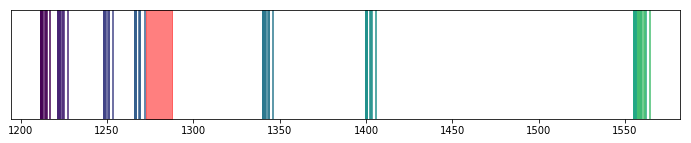

In [40]:
plt.figure(figsize=(12, 2))
for i, li in enumerate(lines_shifted):
    color = plt.matplotlib.cm.viridis(i/(len(li)-1))
    for l in li:
        plt.axvline(l.value, color=color)
        
#gap is at ~1280 in the COS2025 regions, width of 15 ang
plt.fill_between([1280-15/2, 1280+15/2], [1]*2, color='r', alpha=.5)
plt.ylim(0, 1)

plt.yticks([])

### ETC

QSO COS-based spectrum, GALEX/FUV AB mags, S/N of 10, all other default

In [41]:
# maps from mag to time to reach that mag, cy 27

#G130M
# cenwave  1291, S/N @ 1310
sn10time_G130M = {16.5: 1220.7995*u.second,
            17: 1939.6408*u.second,
            17.5: 3086.1907*u.second,
            18: 4921.5940*u.second,
            18.5:  7876.3395*u.second,
            19: 12674.4089*u.second}


#G160M
# cenwave 1533, S/N@ 1560
sn10time_G160M = {16.5: 1379.8606*u.second,
            17: 2193.0624*u.second,
            17.5: 3491.1694*u.second,
            18: 5571.8128*u.second,
            18.5: 8927.8936*u.second,
            19: 14393.8263*u.second}

#G140L 
# cenwave 1280 S/N@1550
sn10time_G140L = {16.5: 171.5051*u.second,
            17: 271.9726*u.second,
            17.5: 431.4380*u.second,
            18: 684.7638*u.second,
            18.5: 1087.7409*u.second,
            19: 1730.1408*u.second}

In [42]:
OBS_TIME_PER_ORBIT = 45*u.min

def compute_orbits(tab, sample=None, magnm='FUV_MAG', time_to_sn=sn10time_G130M, time_per_orbit=OBS_TIME_PER_ORBIT, intify=True):
    mags = tab[magnm]
    if isinstance(sample, str):
        samplecol = tab[sample]
    elif sample is None:
        samplecol = slice(None)
    else:
        samplecol = sample
        
    mag_to_interp = list(time_to_sn.keys())
    orb_for_interp = (u.Quantity(list(time_to_sn.values()))/time_per_orbit).decompose().value
    
    orbitfracs = [np.interp(mag, mag_to_interp, orb_for_interp) for mag in mags[samplecol]]
    
    if intify:
        orbits = np.ceil(orbitfracs).astype(int)
    else:
        orbits = orbitfracs
        
    return np.sum(orbits), orbits

In [43]:
qso_selection = matched_qsos_saga.copy()

# note that we eliminate this one object because it is likely to be a Lyman Limit System based on its FUV-NUV color
bad_one = qso_selection['OBJECT_NAME']=='LBQS 1444-0019           '
qso_selection = qso_selection[~bad_one]

target_qsos_130 = qso_selection[qso_selection['hsla_match_idx'].mask]
target_qsos_160 = qso_selection[qso_selection['hsla_match_idx']!=287]

orbs130 = compute_orbits(target_qsos_130, time_to_sn=sn10time_G130M)
orbs160 = compute_orbits(target_qsos_160, time_to_sn=sn10time_G160M)

print(orbs130)
print(orbs160)
orbs130[0] + orbs160[0]

(19, array([1, 2, 2, 2, 3, 4, 5]))
(33, array([1, 2, 2, 2, 2, 3, 4, 5, 6, 6]))


52

small version:

In [44]:
qso_selection = matched_qsos_saga.copy()

# note that we eliminate this one object because it is likely to be a Lyman Limit System based on its FUV-NUV color
bad_one = qso_selection['OBJECT_NAME']=='LBQS 1444-0019           '
qso_selection = qso_selection[~bad_one]

target_qsos_130 = qso_selection[qso_selection['hsla_match_idx'].mask]
target_qsos_140 = qso_selection[qso_selection['hsla_match_idx']!=287]

orbs130 = compute_orbits(target_qsos_130, time_to_sn=sn10time_G130M)
orbs140 = compute_orbits(target_qsos_140, time_to_sn=sn10time_G140L)

print(orbs130)
print(orbs140)
orbs130[0] + orbs140[0]

(19, array([1, 2, 2, 2, 3, 4, 5]))
(10, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))


29

In [48]:
uqnms = np.unique(list(target_qsos_130['OBJECT_NAME']) + list(target_qsos_140['OBJECT_NAME']))
orbmap = {nm:0 for nm in uqnms}
for nm, orbnum in zip(target_qsos_130['OBJECT_NAME'], orbs130[1]):
    orbmap[nm] += orbnum
for nm, orbnum in zip(target_qsos_140['OBJECT_NAME'], orbs140[1]):
    orbmap[nm] += orbnum

#orbmap = {nm.strip():val for nm, val in orbmap.items()}

assert len(orbmap) == len(target_qsos_140)
for nm in target_qsos_140['OBJECT_NAME']:
    print(nm, orbmap[nm])
print('G130M: 1327', 'G140L: 1280')

FBQS J095820.9+322402     2
SDSS J095914.85+320357.2  1
SDSS J120233.08+022559.7  3
2MASX J12022678-0129155   3
UVQSJ170043.71+223700.2 3
SDSS J142940.73+032125.8  1
SBS 1421+511              4
TON 1129                  5
2MASX J14515156+5914001   6
SDSS J143145.99+030143.8  1
G130M: 1327 G140L: 1280


In [49]:
target_qsos_130['orbits'] = orbs130[1]
target_qsos_160['orbits'] = orbs160[1]

res = table.join(target_qsos_130['OBJECT_NAME', 'orbits'], target_qsos_160['OBJECT_NAME', 'orbits', 'FUV_MAG'], 
                 keys='OBJECT_NAME', table_names=['130', '160'], join_type='outer')
res.sort('FUV_MAG')
res['orbits_all'] = res['orbits_130'].filled(0) +  res['orbits_160'].filled(0)
res

OBJECT_NAME,orbits_130,orbits_160,FUV_MAG,orbits_all
str80,int64,int64,float64,int64
FBQS J095820.9+322402,1,1,17.137916564941406,2
SDSS J095914.85+320357.2,--,2,17.528425216674805,2
SDSS J120233.08+022559.7,2,2,17.655315399169922,4
2MASX J12022678-0129155,2,2,17.832124710083008,4
UVQSJ170043.71+223700.2,2,2,17.92194366455078,4
SDSS J142940.73+032125.8,--,3,18.200599670410156,3
SBS 1421+511,3,4,18.38580894470215,7
TON 1129,4,5,18.674198150634766,9
2MASX J14515156+5914001,5,6,18.982746124267578,11


In [50]:
matched_qsos_saga[matched_qsos_saga['hsla_match_idx'].mask]

OBJECT_NAME,RA,DEC,FUV_MAG,NUV_MAG,Z,r,hsla_match_idx,latercos_match_idx,qso_to_host,qso_to_host_phys,SAGA_name,SAGA_NSAID,SAGA_PGC,coord,host_z
,deg,deg,,,,,,,deg,kpc,,,,"deg,deg",
str80,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str8,int64,int64,object,float64
FBQS J095820.9+322402,149.58726501464844,32.4006233215332,17.137916564941406,16.465614318847656,0.5306000113487244,16.020999908447266,--,--,0.030729590254148807,13.480342651564731,MobyDick,85746,28805,"149.58726501464844,32.4006233215332",0.00484111578283934
SDSS J120233.08+022559.7,180.6378631591797,2.4332659244537354,17.655315399169922,17.676992416381836,0.27300000190734863,17.270000457763672,--,--,0.4580539247957969,235.97350803693132,Sopranos,13927,38031,"180.6378631591797,2.4332659244537354",0.00654165889656904
2MASX J12022678-0129155,180.6114959716797,-1.487576961517334,17.832124710083008,17.52016258239746,0.15039999783039093,17.131000518798828,--,--,0.6431924808082065,260.9858728800687,Alice,140594,37845,"180.6114959716797,-1.487576961517334",0.004886713994652928
UVQSJ170043.71+223700.2,255.182125,22.616722222222222,17.92194366455078,17.54443359375,0.44513264298439026,-1.0,--,--,0.39511411036462246,271.8088804304997,mmt18_4,147606,59426,"255.182125,22.616722222222222",0.009306438256028443
SBS 1421+511,215.80909729003906,50.927024841308594,18.38580894470215,18.708524703979492,0.2757999897003174,17.672000885009766,--,--,0.44986998210657064,268.16974060635937,mmt18_3,144953,51340,"215.80909729003906,50.927024841308594",0.007438479322918791
TON 1129,149.0967254638672,32.60601806640625,18.674198150634766,18.040430068969727,0.5263000130653381,17.56999969482422,--,--,0.4769400366704873,209.2222859268354,MobyDick,85746,28805,"149.0967254638672,32.60601806640625",0.00484111578283934
LBQS 1444-0019,221.69322204589844,-0.5288329720497131,18.922800064086914,18.06130027770996,0.6976000070571899,17.888999938964844,--,--,0.33947405386486856,150.45081554412903,Dune,165536,52735,"221.69322204589844,-0.5288329720497131",0.005535029170080055
2MASX J14515156+5914001,222.96473693847656,59.23335647583008,18.982746124267578,18.68926429748535,0.2971000075340271,18.381999969482422,--,--,0.2652877754890191,155.09967612443427,mmt18_14,165707,53043,"222.96473693847656,59.23335647583008",0.007146977660125126


What about adding in the additional "3" (PGC9843):

In [51]:
matched_qsos[matched_qsos['SAGA_PGC']==9843]

OBJECT_NAME,RA,DEC,FUV_MAG,NUV_MAG,Z,r,hsla_match_idx,latercos_match_idx,qso_to_host,qso_to_host_phys,SAGA_name,SAGA_NSAID,SAGA_PGC,coord
,deg,deg,,,,,,,deg,kpc,,,,"deg,deg"
str80,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str8,int64,int64,object
UVQSJ023437.83-084716.0,38.657624999999996,-8.787777777777778,15.094728469848633,14.887340545654297,0.043058764189481735,-1.0,287,--,0.6043853904367612,216.1707181833966,--,132278,9843,"38.657624999999996,-8.787777777777778"
SDSS J023529.10-092512.6,38.87125778198242,-9.420187950134277,18.727455139160156,20.274492263793945,1.7803000211715698,19.527999877929688,661,--,0.06423096206921533,22.97350898915483,--,132278,9843,"38.87125778198242,-9.420187950134277"
SDSS J023310.63-090940.8,38.29431915283203,-9.16134262084961,18.74440574645996,18.496484756469727,0.3880000114440918,18.12299919128418,--,--,0.5965587585697538,213.37136423073838,--,132278,9843,"38.29431915283203,-9.16134262084961"


In [52]:
t1 = matched_qsos_saga.copy()
t2 = matched_qsos[matched_qsos['SAGA_PGC']==9843]
del t1['coord'], t2['coord']
qso_selection_plus3 = table.vstack([t1, t2])
qso_selection_plus3

OBJECT_NAME,RA,DEC,FUV_MAG,NUV_MAG,Z,r,hsla_match_idx,latercos_match_idx,qso_to_host,qso_to_host_phys,SAGA_name,SAGA_NSAID,SAGA_PGC,host_z
,deg,deg,,,,,,,deg,kpc,,,,
str80,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,str8,int64,int64,float64
FBQS J095820.9+322402,149.58726501464844,32.4006233215332,17.137916564941406,16.465614318847656,0.5306000113487244,16.020999908447266,--,--,0.030729590254148807,13.480342651564731,MobyDick,85746,28805,0.00484111578283934
SDSS J095914.85+320357.2,149.81187438964844,32.06591033935547,17.528425216674805,16.99718475341797,0.5638999938964844,16.992000579833984,35,--,0.3581665444819515,157.11917100136895,MobyDick,85746,28805,0.00484111578283934
SDSS J120233.08+022559.7,180.6378631591797,2.4332659244537354,17.655315399169922,17.676992416381836,0.27300000190734863,17.270000457763672,--,--,0.4580539247957969,235.97350803693132,Sopranos,13927,38031,0.00654165889656904
2MASX J12022678-0129155,180.6114959716797,-1.487576961517334,17.832124710083008,17.52016258239746,0.15039999783039093,17.131000518798828,--,--,0.6431924808082065,260.9858728800687,Alice,140594,37845,0.004886713994652928
UVQSJ170043.71+223700.2,255.182125,22.616722222222222,17.92194366455078,17.54443359375,0.44513264298439026,-1.0,--,--,0.39511411036462246,271.8088804304997,mmt18_4,147606,59426,0.009306438256028443
SDSS J142940.73+032125.8,217.41976928710938,3.3571879863739014,18.200599670410156,18.245100021362305,0.2531000077724457,18.152000427246094,43,--,0.12389057890187925,53.871288948931536,mmt18_12,165082,51787,0.005410409624114027
SBS 1421+511,215.80909729003906,50.927024841308594,18.38580894470215,18.708524703979492,0.2757999897003174,17.672000885009766,--,--,0.44986998210657064,268.16974060635937,mmt18_3,144953,51340,0.007438479322918791
TON 1129,149.0967254638672,32.60601806640625,18.674198150634766,18.040430068969727,0.5263000130653381,17.56999969482422,--,--,0.4769400366704873,209.2222859268354,MobyDick,85746,28805,0.00484111578283934


In [53]:
target_qsos_130_plus3 = qso_selection[qso_selection['hsla_match_idx'].mask]
target_qsos_160_plus3 = qso_selection[qso_selection['hsla_match_idx']!=287]


orbs130_plus3 = compute_orbits(target_qsos_130_plus3, time_to_sn=sn10time_G130M)
orbs160_plus3 = compute_orbits(target_qsos_160_plus3, time_to_sn=sn10time_G160M)

print(orbs130_plus3)
print(orbs160_plus3)
orbs130_plus3[0] + orbs160_plus3[0]

(19, array([1, 2, 2, 2, 3, 4, 5]))
(33, array([1, 2, 2, 2, 2, 3, 4, 5, 6, 6]))


52

Resulting strategy: everything with FUV_MAG<19 around a SAGA host + PGC9843

In [54]:
target_qsos = tab_hosts.copy()

target_hosts = tab_saga_hosts[np.in1d(tab_saga_hosts['PGC'], np.unique(qso_selection['SAGA_PGC']))]
target_hosts2 = tab_hosts[np.in1d(tab_hosts['PGC'], np.unique(qso_selection['SAGA_PGC']))]
del target_hosts['coord'], target_hosts2['coord']
missing = np.array([row['PGC'] not in target_hosts['PGC'] for row in target_hosts2])
target_hosts = table.vstack([target_hosts, target_hosts2[missing]])
add_coord_to_tab(target_hosts)

target_hosts

HOSTID,SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,decals_dr7,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_combined_fuv_lt_19,n_combined_fuv_lt_18.5,n_combined_fuv_lt_18,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
str9,str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,object
nsa85746,MobyDick,85746,149.588,32.3699,28805,413265,3067,5351,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,--,0.978734,149.588,32.3699,09582107+3222116,1451.33,-1,25.1343,0.401621,13.8392,0.00354317,0.0627641,-18.2411,12.514,0.000537367,0.0489054,-19.5442,11.7926,0.00051166,0.0338325,-20.2479,11.4313,0.000435475,0.0251412,-20.5994,11.1085,0.00110246,0.0187004,-20.9154,9.886,0.011,0.0104977,-22.1253,9.156,0.015,0.00664805,-22.8525,8.904,0.015,0.00447152,-23.0925,7680000000,0.932093,-23.1023,0.0,0.8620689511,0.7513061762,1.0,3,2,2,3,2,2,"149.588,32.3699"
nsa140594,Alice,140594,180.098,-1.10008,37845,627617,4030,6993,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,180.098,-1.10008,g1200236-010600,1465.0,-1,23.2487,0.508479,12.5696,0.00122745,0.112339,-19.3871,11.1341,0.00028931,0.0875336,-20.795,10.3932,0.000242571,0.0605553,-21.5041,9.98552,0.000254046,0.0449991,-21.896,9.68725,0.000379465,0.0334711,-22.1818,8.271,0.009,0.0187894,-23.5789,7.604,0.012,0.0118991,-24.24,7.33,0.015,0.00800337,-24.5004,20600000000,1.7545,-24.511,0.0,0.9718163013,0.0,0.9718163013,1,1,1,1,1,1,"180.098,-1.10008"
nsa13927,Sopranos,13927,180.676,1.9768,38031,67580,4045,7021,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,180.676,1.9768,12024224+0158364,1961.14,-1,29.5168,0.274163,13.8217,0.00447421,0.0945623,-18.6446,12.1464,0.000997383,0.0736823,-20.2948,11.276,0.000807301,0.050973,-21.1343,10.8059,0.000719835,0.0378784,-21.5905,10.4349,0.00130936,0.0281746,-21.9503,9.742,0.017,0.0158161,-22.624,9.07,0.018,0.0100161,-23.2915,8.751,0.026,0.00673692,-23.5937,19800000000,3.12889,-23.6073,0.0,0.9801462889,0.0,0.9801462889,1,1,1,1,1,1,"180.676,1.9768"
nsa144953,mmt18_3,144953,215.579,50.5014,51340,631628,5602,9210,2230.0,34.1543,12.73,12.3754,12.1022,11.36,9.589,0.034,0,-23.0782,-19.9373,60.9291,10.6058,11.408,0.98866,215.579,50.5014,NGC_5602,2230.0,-1,34.1543,0.166161,14.6887,0.0277383,0.0845753,-18.0876,12.8071,0.00155138,0.0659005,-19.9454,11.9989,0.00132423,0.0455897,-20.7215,11.6129,0.00132934,0.033878,-21.0954,11.3127,0.00194438,0.025199,-21.3843,10.476,0.019,0.0141458,-22.2028,9.871,0.024,0.00895832,-22.8044,9.596,0.032,0.00602542,-23.0615,13600000000,5.17427,-23.0782,0.0,0.0,1.0,0.0,1,1,0,1,1,0,"215.579,50.5014"
nsa165082,mmt18_12,165082,217.418,3.23331,51787,681573,5638,9308,1622.0,24.9139,11.7737,11.3893,11.1075,--,8.241,0.022,0,-23.7412,-20.2085,56.502,5.16472,10.063,0.973196,217.418,3.23331,NGC_5638,1622.0,-1,24.9139,0.527096,13.7581,0.00241023,0.139358,-18.3801,11.8819,0.000546908,0.108587,-20.2235,11.0727,0.000633886,0.0751199,-20.9903,10.6484,0.000481217,0.0558222,-21.39

# X-match sats 

First we need to get any missing saga catalogs

In [55]:
host_id_label = 'ID_STR'
target_hosts[host_id_label] = ['nsa{}'.format(row['NSAID']) if row['NSAID']!=-1 else 'pgc{}'.format(row['PGC']) for row in target_hosts]

In [56]:
from SAGA.database.external import SdssQuery, WiseQuery, DesQuery, DecalsPrebuilt, download_catalogs_for_hosts


sdssfail = download_catalogs_for_hosts(target_hosts, SdssQuery, saga_database.sdss_file_path_pattern, 
                                 overwrite=False, host_id_label=host_id_label)

desfail = download_catalogs_for_hosts(target_hosts, DesQuery, saga_database.des_file_path_pattern, 
                                      overwrite=False, host_id_label=host_id_label)
decfail = download_catalogs_for_hosts(target_hosts, DecalsPrebuilt, saga_database.decals_file_path_pattern, 
                                      overwrite=False, host_id_label=host_id_label)

sdssfail, desfail, decfail

[04/05 16:24:40] Getting catalog for host nsa85746 ...
[04/05 16:24:40] Getting catalog for host nsa140594 ...
[04/05 16:24:40] Getting catalog for host nsa13927 ...
[04/05 16:24:40] Getting catalog for host nsa144953 ...
[04/05 16:24:40] Getting catalog for host nsa165082 ...
[04/05 16:24:40] Getting catalog for host nsa165707 ...
[04/05 16:24:40] Getting catalog for host nsa147606 ...
[04/05 16:24:40] Getting catalog for host nsa85746 ...
[Errno 2] No such file or directory: ''
[04/05 16:24:40] Fail to get catalog for host nsa85746
[04/05 16:24:40] Getting catalog for host nsa140594 ...
[Errno 2] No such file or directory: ''
[04/05 16:24:41] Fail to get catalog for host nsa140594
[04/05 16:24:41] Getting catalog for host nsa13927 ...
[Errno 2] No such file or directory: ''
[04/05 16:24:41] Fail to get catalog for host nsa13927
[04/05 16:24:41] Getting catalog for host nsa144953 ...
[Errno 2] No such file or directory: ''
[04/05 16:24:42] Fail to get catalog for host nsa144953
[04/05

(array([False, False, False, False, False, False, False]),
 array([ True,  True,  True,  True,  True,  True,  True]),
 array([False, False, False, False, False, False, False]))

Now build any missing base catalogs

In [57]:
for row in target_hosts:
    name = row[host_id_label]
    print('building', name)
    saga_object_catalog.build_and_write_to_database(name, overwrite=True)

building nsa85746
[04/05 16:27:01] [WARNING] Not found: DES catalog for nsa85746.
[04/05 16:27:03] Use SDSS, DECALS to build base catalog v2 for nsa85746 (1/1)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[04/05 16:28:08] Write base catalog to /Users/erik/projects/saga/erik/base_catalogs/base_v2_nsa85746.fits.gz
building nsa140594
[04/05 16:29:14] [WARNING] Not found: DES catalog for nsa140594.
[04/05 16:29:19] Use SDSS, DECALS to build base catalog v2 for nsa140594 (1/1)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[04/05 16:31:48] Write base catalog to /Users/erik/projects/saga/erik/base_catalogs/base_v2_nsa140594.fits.gz
building nsa13927
[04/05 16:33:07] [WARNING] Not found: DES catalog for nsa13927.
[04/05 16:33:12] Use SDSS, DECALS to build base catalog v2 for nsa13927 (1/1)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[04/05 16:35:12] Write base catalog to /Users/erik/projects/saga/erik/base_catalogs/base_v2_nsa13927.fits.gz
building nsa144953
[04/05 16:36:30] [WARNING] Not found: DES catalog for nsa144953.
[04/05 16:36:32] Use SDSS, DECALS to build base catalog v2 for nsa144953 (1/1)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[04/05 16:37:28] Write base catalog to /Users/erik/projects/saga/erik/base_catalogs/base_v2_nsa144953.fits.gz
building nsa165082
[04/05 16:38:33] [WARNING] Not found: DES catalog for nsa165082.
[04/05 16:38:36] Use SDSS, DECALS to build base catalog v2 for nsa165082 (1/1)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[04/05 16:40:16] Write base catalog to /Users/erik/projects/saga/erik/base_catalogs/base_v2_nsa165082.fits.gz
building nsa165707
[04/05 16:41:27] [WARNING] Not found: DES catalog for nsa165707.
[04/05 16:41:29] Use SDSS, DECALS to build base catalog v2 for nsa165707 (1/1)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[04/05 16:42:30] Write base catalog to /Users/erik/projects/saga/erik/base_catalogs/base_v2_nsa165707.fits.gz
building nsa147606
[04/05 16:43:37] [WARNING] Not found: DES catalog for nsa147606.
[04/05 16:43:40] Use SDSS, DECALS to build base catalog v2 for nsa147606 (1/1)


/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


[04/05 16:45:03] Write base catalog to /Users/erik/projects/saga/erik/base_catalogs/base_v2_nsa147606.fits.gz


In [58]:
host_row_to_catalog = {}
allsats = []
for i, row in enumerate(target_hosts):
    host_row_to_catalog[i] = cat = saga_object_catalog.load(row[host_id_label])[0]
    allsats.append(ocuts.is_sat.filter(cat))
    del allsats[-1]['coord']
allsats = table.vstack(allsats)
add_coord_to_tab(allsats, decname='DEC');

/Users/erik/projects/saga/saga/build/lib/SAGA/objects/object_catalog.py:66: RuntimeWarning: invalid value encountered in subtract
  table[color] = table['{}_mag'.format(color[0])] - table['{}_mag'.format(color[1])]


And cross-match them

In [59]:
def get_sat_closest(sattab, qsotab, sorton=None):
    idx, d2d, _ = sattab['coord'].match_to_catalog_sky(qsotab['coord'], nthneighbor=1)
    tab = qsotab[idx]
    tab['match_d2d'] = d2d
    tab['match_d2d_phys'] = (d2d.radian*sattab['HOST_DIST']*u.Mpc).to(u.kpc)
    
    if sorton is not None:
        #trick to make sort work
        sorti = np.argsort(tab[sorton])
        tab = tab[sorti]
        sattab = sattab[sorti]
    return table.hstack((sattab, tab), table_names=['sat', 'qso'])

In [60]:
sat_matches = get_sat_closest(allsats, tab_qso19, sorton='match_d2d_phys')
sat_matches_combined = get_sat_closest(allsats, tab_qsos_combined, sorton='match_d2d_phys')

In [61]:
sat_matches_combined['RA_sat', 'DEC_sat', 'RA_qso', 'DEC_qso', 'TELNAME', 'HOST_SAGA_NAME', 'match_d2d_phys'].show_in_notebook()

idx,RA_sat,DEC_sat,RA_qso,DEC_qso,TELNAME,HOST_SAGA_NAME,match_d2d_phys
,,,deg,deg,,,kpc
0,217.86348991150788,3.0091635379966744,217.94163513183594,3.028848886489868,NSA,,34.995677177215484
1,217.41257161258602,3.266285795439988,217.41976928710938,3.3571879863739014,NSA,,39.65026460609664
2,217.26621891520384,3.1489905554887674,217.41976928710938,3.3571879863739014,NSA,,112.42505103017974
3,217.81893353616692,3.2567384880858876,217.94163513183594,3.028848886489868,MMT,,112.50586824770978
4,217.67292879868697,3.425723527320057,217.41976928710938,3.3571879863739014,NSA,,113.85775286731074
5,255.37350163249866,22.731133865735693,255.182125,22.616722222222222,MMT,,144.74660740711641
6,149.68700425500853,32.72035396984093,149.58726501464844,32.4006233215332,MMT,MobyDick,145.02492773785482
7,180.29544158915624,-1.297683895678335,180.6114959716797,-1.487576961517334,NSA,Alice,149.57906805429676
8,217.9707567106337,3.3800403176706824,217.94163513183594,3.028848886489868,MMT,,153.23090940106795


In [62]:
nms = ['SAT_{}_{:.0f}kpc'.format(i, row['match_d2d_phys']) for i, row in enumerate(sat_matches_combined)]
print(targeting.sampled_imagelist(sat_matches_combined['RA_sat'], sat_matches_combined['DEC_sat'], 
                                  n=len(sat_matches_combined), 
                                  names=nms, **imagelist_kwargs))

name ra dec
SAT_0_35kpc 217.86348991150788 3.0091635379966744
SAT_1_40kpc 217.41257161258602 3.266285795439988
SAT_2_112kpc 217.26621891520384 3.1489905554887674
SAT_3_113kpc 217.81893353616692 3.2567384880858876
SAT_4_114kpc 217.67292879868697 3.425723527320057
SAT_5_145kpc 255.37350163249866 22.731133865735693
SAT_6_145kpc 149.68700425500853 32.72035396984093
SAT_7_150kpc 180.29544158915624 -1.297683895678335
SAT_8_153kpc 217.9707567106337 3.3800403176706824
SAT_9_164kpc 222.9003481276424 58.954733388003966
SAT_10_174kpc 255.13818876770836 22.865991401166823
SAT_11_185kpc 217.5077014008536 3.77290518411652
SAT_12_208kpc 255.3575910437891 22.872974240410265
SAT_13_227kpc 217.70061004360554 3.796388769547217
SAT_14_230kpc 217.23277401294135 3.8515685760734075
SAT_15_284kpc 217.33157059631858 2.7105423683853176
SAT_16_294kpc 255.18786111398725 23.04398082820226
SAT_17_303kpc 222.51841245396474 58.76842007137108
SAT_18_345kpc 255.06076741256138 23.106336431747785
SAT_19_347kpc 215.459030

In [63]:
nms = ['QSO_{}_{:.0f}kpc'.format(i, row['match_d2d_phys']) for i, row in enumerate(sat_matches_combined)]
print(targeting.sampled_imagelist(sat_matches_combined['RA_qso'], sat_matches_combined['DEC_qso'], 
                                  n=len(sat_matches_combined), 
                                  names=nms, **imagelist_kwargs))

name ra dec
QSO_0_35kpc 217.94163513183594 3.028848886489868
QSO_1_40kpc 217.41976928710938 3.3571879863739014
QSO_2_112kpc 217.41976928710938 3.3571879863739014
QSO_3_113kpc 217.94163513183594 3.028848886489868
QSO_4_114kpc 217.41976928710938 3.3571879863739014
QSO_5_145kpc 255.182125 22.616722222222222
QSO_6_145kpc 149.58726501464844 32.4006233215332
QSO_7_150kpc 180.6114959716797 -1.487576961517334
QSO_8_153kpc 217.94163513183594 3.028848886489868
QSO_9_164kpc 222.96473693847656 59.23335647583008
QSO_10_174kpc 255.182125 22.616722222222222
QSO_11_185kpc 217.41976928710938 3.3571879863739014
QSO_12_208kpc 255.182125 22.616722222222222
QSO_13_227kpc 217.41976928710938 3.3571879863739014
QSO_14_230kpc 217.41976928710938 3.3571879863739014
QSO_15_284kpc 217.41976928710938 3.3571879863739014
QSO_16_294kpc 255.182125 22.616722222222222
QSO_17_303kpc 222.96473693847656 59.23335647583008
QSO_18_345kpc 255.182125 22.616722222222222
QSO_19_347kpc 215.80909729003906 50.927024841308594
QSO_20_3

In [64]:
# this first step combined the above two X-matches so that the matched_qso table contains info 
# about the nearby satellites

add_coord_to_tab(qso_selection, 'RA', 'DEC')

sat_seps = []
for i, row in enumerate(qso_selection):
    seps = row['coord'].separation(sat_matches_combined['coord_sat'])
    
    dfactor = np.array(row['qso_to_host_phys']/row['qso_to_host'])*u.kpc/u.deg
    seps = seps.to(u.deg)*dfactor
    sat_seps.append(seps[seps<600*u.kpc])
 
qso_selection['sat_seps'] = sat_seps
sat_seps

[<Quantity [145.0249264] kpc>,
 <Quantity [290.79098398] kpc>,
 <Quantity [] kpc>,
 <Quantity [149.57907328, 373.238106  ] kpc>,
 <Quantity [144.74661005, 173.72938277, 208.48904462, 293.9443827 ,
            345.49090099, 404.36359212, 428.1820397 ] kpc>,
 <Quantity [244.97594661,  39.65026401, 112.42504934, 178.69959812,
            113.85775115, 239.37799796, 184.75034274, 226.55476711,
            229.7781155 , 283.77675992] kpc>,
 <Quantity [347.28253756, 354.52694379, 477.71878998] kpc>,
 <Quantity [223.68708437] kpc>,
 <Quantity [164.03963297, 303.22966252] kpc>,
 <Quantity [ 34.99567665, 251.84111754, 297.88089041, 112.50586655,
            208.30263609, 153.23090709, 374.37108966, 349.76191265,
            471.85195232, 298.91614893] kpc>]

### Write out QSOs  for sharing

In [146]:
towrite = qso_selection['OBJECT_NAME','RA', 'DEC', 'Z', 'FUV_MAG', 'qso_to_host_phys', 'SAGA_name', 'SAGA_NSAID', 'SAGA_PGC', 'sat_seps']
towrite['in_proposal'] = qso_selection['hsla_match_idx'].mask

idxarr = -np.ones(len(qso_selection), dtype=int)
msk = qso_selection['hsla_match_idx'].mask.copy()
idxarr[~msk] = qso_selection['hsla_match_idx'][~msk]
towrite['hsla_match_idx'] = idxarr

towrite.write('SAGACOS_QSOs27.ecsv', format='ascii.ecsv')
towrite

OBJECT_NAME,RA,DEC,Z,FUV_MAG,qso_to_host_phys,SAGA_name,SAGA_NSAID,SAGA_PGC,sat_seps,in_proposal,hsla_match_idx
,deg,deg,,,kpc,,,,,,
str80,float64,float64,float64,float64,float64,str8,int64,int64,object,bool,int64
FBQS J095820.9+322402,149.58726501464844,32.4006233215332,0.5306000113487244,17.137916564941406,13.480342651564731,MobyDick,85746,28805,[145.00287179] kpc,True,-1
SDSS J095914.85+320357.2,149.81187438964844,32.06591033935547,0.5638999938964844,17.528425216674805,157.11917100136895,MobyDick,85746,28805,[290.74296243] kpc,False,35
SDSS J120233.08+022559.7,180.6378631591797,2.4332659244537354,0.27300000190734863,17.655315399169922,235.97350803693132,Sopranos,13927,38031,[] kpc,True,-1
2MASX J12022678-0129155,180.6114959716797,-1.487576961517334,0.15039999783039093,17.832124710083008,260.9858728800687,Alice,140594,37845,[149.57907328 373.238106 ] kpc,True,-1
UVQSJ170043.71+223700.2,255.182125,22.616722222222222,0.44513264298439026,17.92194366455078,271.8088804304997,mmt18_4,147606,59426,[144.79427306 173.72938277 208.469985 293.9443827 345.49090099 404.36359212 428.1820397 ] kpc,True,-1
SDSS J142940.73+032125.8,217.41976928710938,3.3571879863739014,0.2531000077724457,18.200599670410156,53.871288948931536,mmt18_12,165082,51787,[244.97594661 39.65026401 112.42504934 178.69959812 113.85775115 239.37799796 184.75034274 226.55476711 229.7781155 283.77675992] kpc,False,43
SBS 1421+511,215.80909729003906,50.927024841308594,0.2757999897003174,18.38580894470215,268.16974060635937,mmt18_3,144953,51340,[347.28253756 354.52694379 477.71878998] kpc,True,-1
TON 1129,149.0967254638672,32.60601806640625,0.5263000130653381,18.674198150634766,209.2222859268354,MobyDick,85746,28805,[223.73773046] kpc,True,-1


# Target Name, RA, DEC, V-Magnitude, "Mag Uncertainty", "Other Fluxes"
M100, 12 22 , +15 49 16.0, 13.5, 0.2, B=13.4 
SS433, 19 09 53.0, +4 53 16 , 14.5, 0.2, 
V1315-AQL, 19 13 54. , 12 18 , 15.3, , B-V = 0.65 
U-SCO, 16h 22m 31.0s , -17d 52m 44.s , , , "B=19.5; U-B=-0.5" 
U-GEM, 118.77170, 22.00137, 8.8, , 

In [147]:
medrmf = np.median(qso_selection['r']-qso_selection['FUV_MAG'])
medrmf

/Users/erik/miniconda3/envs/saga3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


-0.650935173034668

In [148]:
#also the format needed by APT

target_table = qso_selection['OBJECT_NAME', 'RA', 'DEC', 'r']
target_table.meta = {}
target_table.rename_column('OBJECT_NAME', 'Target Name')
target_table['Target Name'] = [n.replace(' ', '') for n in target_table['Target Name']]
target_table.rename_column('r', 'V-Magnitude')
nor = target_table['V-Magnitude'] == -1
target_table['V-Magnitude'][nor] = qso_selection['FUV_MAG'][nor] + medrmf
target_table['V-Magnitude'].format = '.2f'
target_table['Mag Uncertainty'] = ''
target_table['Other Fluxes'] = ['FUV={:.2f}'.format(row['FUV_MAG']) for row in qso_selection]
target_table.write('hst26_sagacos_targets.csv', format='ascii.commented_header', delimiter=',', fast_writer=False)
!cat hst26_sagacos_targets.csv

# Target Name,RA,DEC,V-Magnitude,Mag Uncertainty,Other Fluxes
FBQSJ095820.9+322402,149.58726501464844,32.4006233215332,16.02,,FUV=17.14
SDSSJ095914.85+320357.2,149.81187438964844,32.06591033935547,16.99,,FUV=17.53
SDSSJ120233.08+022559.7,180.6378631591797,2.4332659244537354,17.27,,FUV=17.66
2MASXJ12022678-0129155,180.6114959716797,-1.487576961517334,17.13,,FUV=17.83
UVQSJ170043.71+223700.2,255.182125,22.616722222222222,17.27,,FUV=17.92
SDSSJ142940.73+032125.8,217.41976928710938,3.3571879863739014,18.15,,FUV=18.20
SBS1421+511,215.80909729003906,50.927024841308594,17.67,,FUV=18.39
TON1129,149.0967254638672,32.60601806640625,17.57,,FUV=18.67
2MASXJ14515156+5914001,222.96473693847656,59.23335647583008,18.38,,FUV=18.98
SDSSJ143145.99+030143.8,217.94163513183594,3.028848886489868,18.82,,FUV=19.00


# Check the spectra that are already observed w/COS

In [149]:
#check that those that are in hsla are actually useful
hsla_to_check_tab = hsla_qso_tab[qso_selection['hsla_match_idx'][~qso_selection['hsla_match_idx'].mask]]
hsla_to_check_tab['SAGA_NSAID'] = qso_selection[~qso_selection['hsla_match_idx'].mask]['SAGA_NSAID']

baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/{0}/{0}_quicklook.html'
for name in hsla_to_check_tab['Target Name']:
    url = baseurl.format(name)
    print(url)
    
old_proposal_names = ['2MASS-J09591486+3203573', '2MASS-J14294076+0321257', 'J084159.13+140642.1']
#hsla_to_check_tab['new_in_25'] = ~np.in1d(hsla_to_check_tab['Target Name'], from_old_proposal)
    
hsla_to_check_tab

https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/2MASS-J09591486+3203573/2MASS-J09591486+3203573_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/2MASS-J14294076+0321257/2MASS-J14294076+0321257_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/J143145.98+030143.8/J143145.98+030143.8_quicklook.html


Number,Target Name,RA,DEC,Nexp,Target Description,AltName,AltClass,MAST,Median S/N,FUV M,FUV L,NUV M,NUV L,Download,coord,SAGA_NSAID
,,,,,,,,,,,,,,,"deg,deg",
int64,str24,float64,float64,int64,str20,str35,str8,str4,float64,str5,str5,str5,str5,str5,object,int64
36,2MASS-J09591486+3203573,149.812,32.0659,2,GALAXY;QSO,QSO J0959+3203,QSO,MAST,6.21828,--,. . .,. . .,. . .,ALL,"149.812,32.0659",85746
44,2MASS-J14294076+0321257,217.42,3.35718,4,GALAXY;QSO,2MASS J14294076+0321257,Seyfert_,MAST,5.25079,--,. . .,. . .,. . .,ALL,"217.42,3.35718",165082
682,J143145.98+030143.8,217.942,3.02886,9,GALAXY;QSO,2MASS J14314604+0301444,Seyfert_,MAST,6.00749,--,. . .,--,. . .,ALL,"217.942,3.02886",165082


In [150]:
quicklook_baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/{0}/{0}_quicklook.html'
data_baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/{0}/{0}_coadd_G130M_final_all.fits.gz'
data160_baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/{0}/{0}_coadd_G160M_final_all.fits.gz'


spec_tables = []
spec_tables160 = []
for row in hsla_to_check_tab:
    print(quicklook_baseurl.format(row['Target Name']))
    
    try:
        spec_tables.append(table.Table.read(data_baseurl.format(row['Target Name'])))
    except:
        print('G130M not found for', row['Target Name'])
        spec_tables.append(None)
        
    try:
        spec_tables160.append(table.Table.read(data160_baseurl.format(row['Target Name'])))
    except:
        print('G160M not found for', row['Target Name'])
        spec_tables160.append(None)

https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/2MASS-J09591486+3203573/2MASS-J09591486+3203573_quicklook.html
G160M not found for 2MASS-J09591486+3203573
https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/2MASS-J14294076+0321257/2MASS-J14294076+0321257_quicklook.html
G160M not found for 2MASS-J14294076+0321257
https://archive.stsci.edu/missions/hst/spectral_legacy/DR2/datapile/J143145.98+030143.8/J143145.98+030143.8_quicklook.html
G160M not found for J143145.98+030143.8


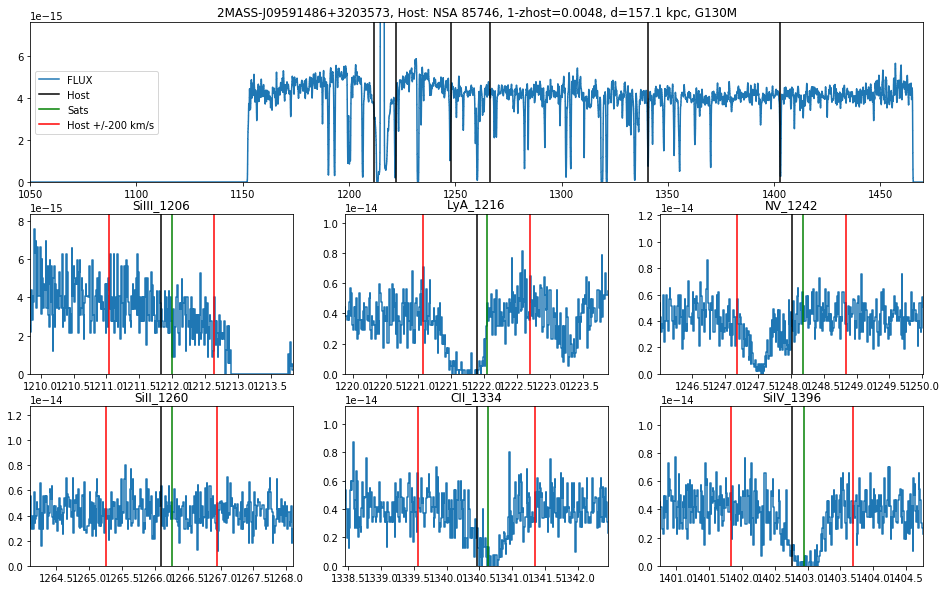

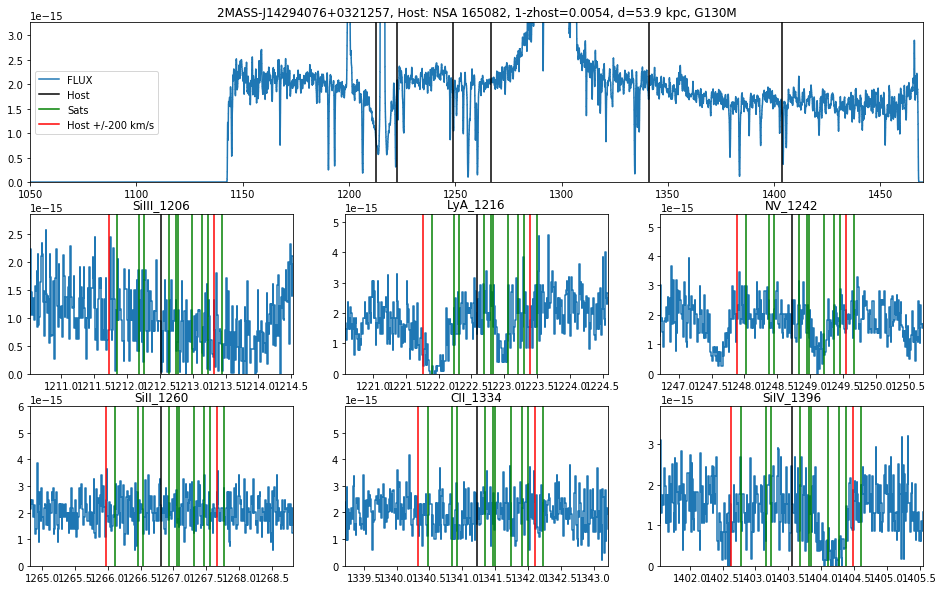

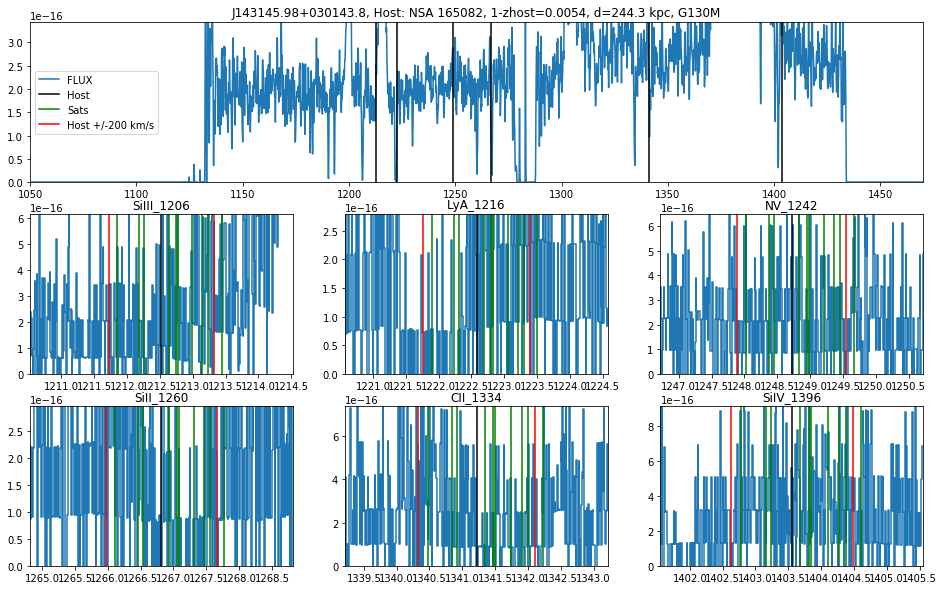

In [153]:
lines130 = ['SiIII_1206', 'LyA_1216', 'NV_1242', 'SiII_1260', 'CII_1334', 'SiIV_1396']
lines160 = ['CIV_1549']

smoothing = None #convolution.Box1DKernel(2.5)
smoothing1 = convolution.Gaussian1DKernel(10)

for row, spec_table130, spec_table160 in zip(hsla_to_check_tab, spec_tables, spec_tables160):
    for spec_table  in (spec_table130, spec_table160 ):
        if spec_table is None:
            continue
            
        is160 = np.mean(spec_table['WAVE'])>1500
        lines = lines160 if is160 else lines130
            
        hostrow = tab_hosts[tab_hosts['NSAID']==row['SAGA_NSAID']][0]
        zhost = (hostrow['vhelio']*u.km/u.s/cnst.c).decompose()

        impact_p = hostrow['coord'].separation(row['coord']).radian*hostrow['distance']*1000*u.kpc

        sats = allsats[allsats['HOST_PGC']==hostrow['PGC']]
        zsats = sats['SPEC_Z']

        wl = spec_table['WAVE']
        if smoothing is None:
            fx = spec_table['FLUX']
        else:
            fx = convolution.convolve(spec_table['FLUX'], smoothing)

        plt.figure()

        ax1 = plt.subplot2grid((3,3), (0,0), colspan=3)
        if smoothing1 is None:
            fx1 = spec_table['FLUX']
        else:
            fx1 = convolution.convolve(spec_table['FLUX'], smoothing1)

        ax1.step(wl, fx1)
        msg = '{0[Target Name]}{4}, Host: NSA {1[NSAID]}, 1-zhost={2:.2}, d={3:.1f}, {5}'
        ax1.set_title(msg.format(row, hostrow, zhost, impact_p, 
                                 '',
                                 'G160M' if is160 else 'G130M'))
        if is160:
            ax1.set_xlim(1400, 1800)
        else:
            ax1.set_xlim(1050, 1470)
        ax1.set_ylim(0, np.median(fx1)*2)

        for i, line in enumerate(lines):
            linenm, linewl = line.split('_')
            linewl = float(linewl)

            plt.subplot(3, 3, i+4)
            plt.step(wl, fx)
            plt.title(line)

            zhostwl = (1+zhost)*linewl
            wlrng = (zhostwl-2, zhostwl+2)
            plt.xlim(*wlrng)

            ax1.axvline(zhostwl, color='k')
            plt.axvline(zhostwl, color='k', label='Host')

            satlab = 'Sats'
            for zsat in zsats:
                plt.axvline((1+zsat)*linewl, c='g', label=satlab)
                satlab=None


            plt.axvline(zhostwl*(1+zhost+200*u.km/u.s/cnst.c)/(1+zhost), color='r', label='Host +/-200 km/s')
            plt.axvline(zhostwl*(1+zhost-200*u.km/u.s/cnst.c)/(1+zhost), color='r')
            plt.ylim(0, np.median(fx[(wlrng[0]<wl)&(wl<wlrng[1])])*3)


        handles, labels = plt.gca().get_legend_handles_labels()
        ax1.legend(handles, labels, loc='center left')

# Proposal plots

In [66]:
hostcolor = '#C23B22'
satcolor = '#779ECB'

## Bullseye plot

In [67]:
# first collect all the data

host_dists = []
host_pas = []
host_grpnums = []

sat_pas = []
sat_dists = []
sat_dzs = []
sat_grpnums = []

host_sat_pas = []
host_sat_dists = []


hosttonum = {'nothing':0}
for qso in qso_selection:
    
    host = tab_hosts[tab_hosts['NSAID']==qso['SAGA_NSAID']]
    sats = allsats[allsats['HOST_NSAID']==qso['SAGA_NSAID']]
    dist = host['distance'][0]*u.Mpc
    
    if host['NSAID'][0] in hosttonum:
        hostnum = hosttonum[host['NSAID'][0]]
    else:
        hostnum = np.max(list(hosttonum.values()))+1
        hosttonum[host['NSAID'][0]] = hostnum
    
    host_dists.append(qso['coord'].separation(host[0]['coord']).radian*dist)
    host_pas.append(qso['coord'].position_angle(host[0]['coord']))
    host_grpnums.append(hostnum)
    
    sat_dists.extend(qso['coord'].separation(sats['coord']).radian*dist)
    sat_pas.extend(qso['coord'].position_angle(sats['coord']))
    hostz = (host['vhelio']/cnst.c.to(u.km/u.s).value)
    sat_dzs.extend(sats['SPEC_Z']-hostz)
    sat_grpnums.extend([hostnum]*len(sats))
    
    host_sat_dists.extend(host[0]['coord'].separation(sats['coord']).radian*dist)
    host_sat_pas.extend(host[0]['coord'].position_angle(sats['coord']))
    
    print(len(sats), qso['SAGA_name'], qso['SAGA_NSAID'])
del hosttonum['nothing']
    
for nm in 'host_dists,sat_dists,host_pas,sat_pas,host_sat_pas,host_sat_dists'.split(','):
    globals()[nm] = u.Quantity(globals()[nm])

1 MobyDick 85746
1 MobyDick 85746
0 Sopranos 13927
2 Alice 140594
7 mmt18_4 147606
10 mmt18_12 165082
3 mmt18_3 144953
1 MobyDick 85746
2 mmt18_14 165707
10 mmt18_12 165082


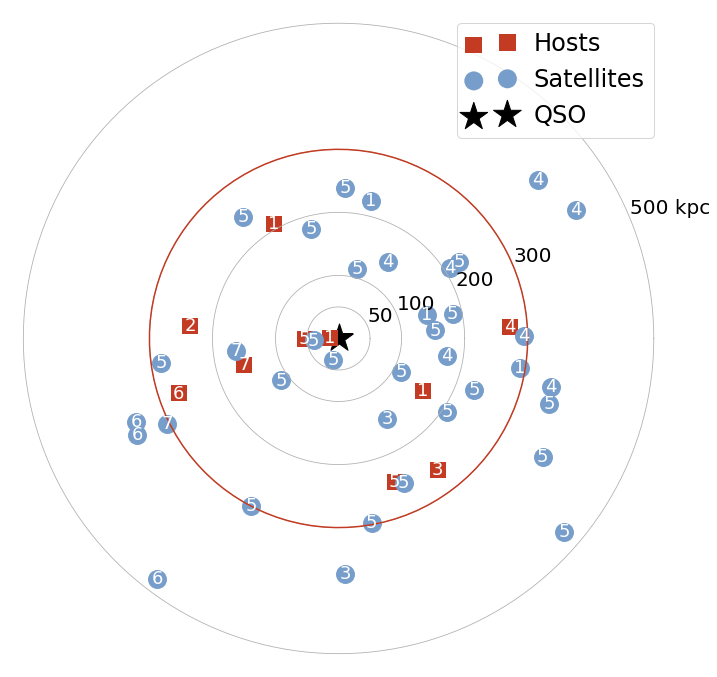

In [69]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection='polar')

ax.plot(np.linspace(0, 2*np.pi,100), [300]*100, c=hostcolor)

hostx = host_pas.to(u.radian).value
hosty = host_dists.to(u.kpc).value
ax.scatter(hostx, hosty, 
           c=hostcolor, s=280, label='Hosts', lw=0, marker='s')
satx = sat_pas.to(u.radian).value
saty = sat_dists.to(u.kpc).value
ax.scatter(satx, saty, 
           c=satcolor, marker='o', s=360, label='Satellites', lw=0)
ax.scatter([0], [0], marker='*', s=850, color='k', label='QSO', zorder=0)

for x, y, num in zip(hostx, hosty, host_grpnums):
    plt.text(x, y, str(num), ha='center', va='center',fontsize=18, color='w')

for x, y, num in zip(satx, saty, sat_grpnums):
    plt.text(x, y, str(num), ha='center', va='center',fontsize=18, color='w')

ax.grid(True)

ax.spines['polar'].set_visible(False)
ax.set_xticks([])
ax.set_ylim(0,520)
ax.legend(loc=0, scatterpoints=2, fontsize=24)

ax.set_yticks([50, 100, 200, 300, 500])
ax.set_yticklabels([u'50', u'100', u'200',u'300' ,u'500 kpc'], fontsize=20)

plt.tight_layout()

#plt.savefig('bullseye.pdf')
#!cp bullseye.pdf /Users/erik/Documents/obsproposals/HST27-SAGACOS/scijust/

In [71]:
hostx

array([6.2629827 , 8.86861567, 6.19987924, 8.50045354, 3.20657451,
       6.29744411, 6.61454705, 5.22799609, 6.5601171 , 8.22699461])

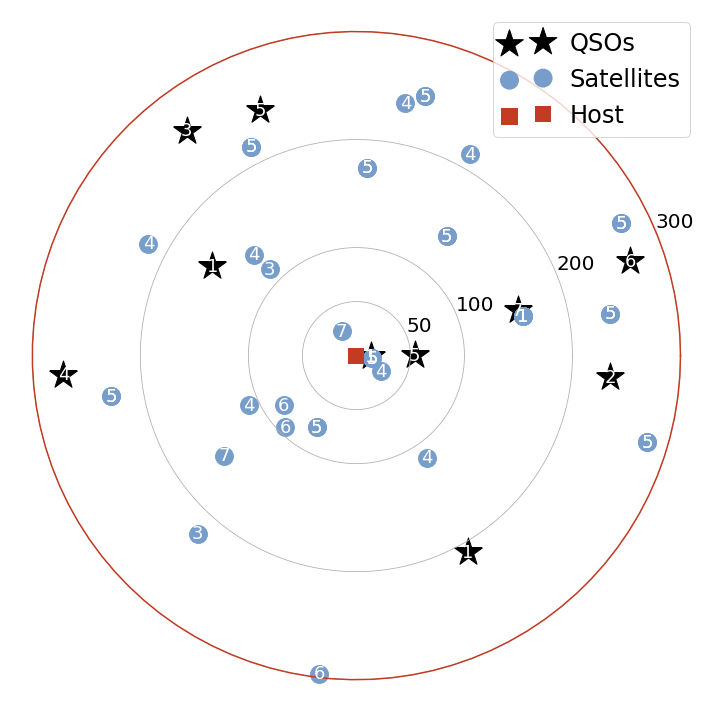

In [72]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection='polar')

ax.plot(np.linspace(0, 2*np.pi,100), [300]*100, c=hostcolor)

hostx = host_pas.to(u.radian).value + np.pi
hosty = host_dists.to(u.kpc).value
ax.scatter(hostx, hosty, 
           marker='*', s=850, color='k', label='QSOs')

satx = host_sat_pas.to(u.radian).value
saty = host_sat_dists.to(u.kpc).value
ax.scatter(satx, saty, 
           c=satcolor, marker='o', s=360, label='Satellites', lw=0)

ax.scatter([0], [0], c=hostcolor, s=280, label='Host', lw=0, marker='s')

for x, y, num in zip(hostx, hosty, host_grpnums):
    plt.text(x, y, str(num), ha='center', va='center',fontsize=18, color='w')

for x, y, num in zip(satx, saty, sat_grpnums):
    plt.text(x, y, str(num), ha='center', va='center',fontsize=18, color='w')

ax.grid(True)

ax.spines['polar'].set_visible(False)
ax.set_xticks([])
ax.set_ylim(0,320)
ax.legend(loc=0, scatterpoints=2, fontsize=24)

ax.set_yticks([50, 100, 200, 300])
ax.set_yticklabels([u'50', u'100', u'200',u'300' ], fontsize=20)

plt.tight_layout()

#plt.savefig('bullseye2.pdf')
#!cp bullseye2.pdf /Users/erik/Documents/obsproposals/HST27-SAGACOS/scijust/

# "Horn" plot a la Tuminson+ 13

In [920]:
#JT's data table for COS-Halos
with open('catalogs/cos_halos_catalog.tab') as f:
    cos_halos_tab_str = f.read()
    
inflags = False
for l in cos_halos_tab_str.split('\n'):
    if '# meaning of flags' in l:
        inflags = True
    if inflags:
        print(l)
    if l.replace('#', '').strip()=='':
        inflags = False
        
cos_halos_tab = table.Table.read(cos_halos_tab_str, format='ascii.commented_header', guess=False,header_start=19)
cos_halos_tab_good = cos_halos_tab[cos_halos_tab['flags']==0]

print(len(cos_halos_tab))
cos_halos_tab[:5].show_in_notebook()

# meaning of flags 
# 0 = OK 
# 1 = weak or uncertain presence 
# 2 = N uncertain, saturation concern 
# 4 = b uncertain, overbroad 
# 8 = Lya only (weak, not confirmed and no other ID) 
# 16 = otherwise bogus 
#
110


idx,flags,QSO,galname,N,Nerr,b,berr,v,verr,SFR,sfrlim,sSFR,mstar,rho
0,1,J0226+0015,268_22,13.03,0.16,16.0,9.5,67.8,5.6,0.1,1,1.29e-12,10.8,80.6
1,0,J0226+0015,268_22,14.34,0.06,40.9,3.5,166.4,2.0,0.1,1,1.29e-12,10.8,80.6
2,0,J0401-0540,67_24,13.63,0.07,23.3,6.5,-643.0,5.0,1.1,0,7.86e-11,10.2,85.6
3,0,J0401-0540,67_24,14.64,0.08,19.9,1.9,-579.6,2.6,1.1,0,7.86e-11,10.2,85.6
4,0,J0401-0540,67_24,15.54,0.09,30.4,4.6,-63.7,5.8,1.1,0,7.86e-11,10.2,85.6


In [921]:
def abundance_matching_mh_to_ms(mh, z=0):
    #based on Moster+ 13 esp. Table 1
    M10 = 11.59
    M11 = 1.195
    N10 = 0.0351
    N11 = -0.0247
    beta10 = 1.376
    beta11 = -0.826
    gamma10 = 0.608
    gamma11 = 0.329
    
    oneminusa = z/(z+1)
    M1 = 10**(M10 + M11*oneminusa)
    N = N10 + N11*oneminusa
    beta = beta10 + beta11*oneminusa
    gamma = gamma10 + gamma11*oneminusa
    
    x = mh/M1
    
    msomh =  2*N/(x**-beta+x**gamma)
    return msomh*mh
    
lastres = None
def abundance_matching_ms_to_mh_scalar(ms, z=0):
    global lastres
    from scipy import optimize
    
    ofun = lambda mh: (abundance_matching_mh_to_ms(mh, z)-ms)**2
    
    res = optimize.minimize_scalar(ofun, (1,ms,1e18))
    lastres = res
    return res['x']
abundance_matching_ms_to_mh = np.vectorize(abundance_matching_ms_to_mh_scalar, excluded=set('z'))

(-24.586336236559145, -23.002863763440857)

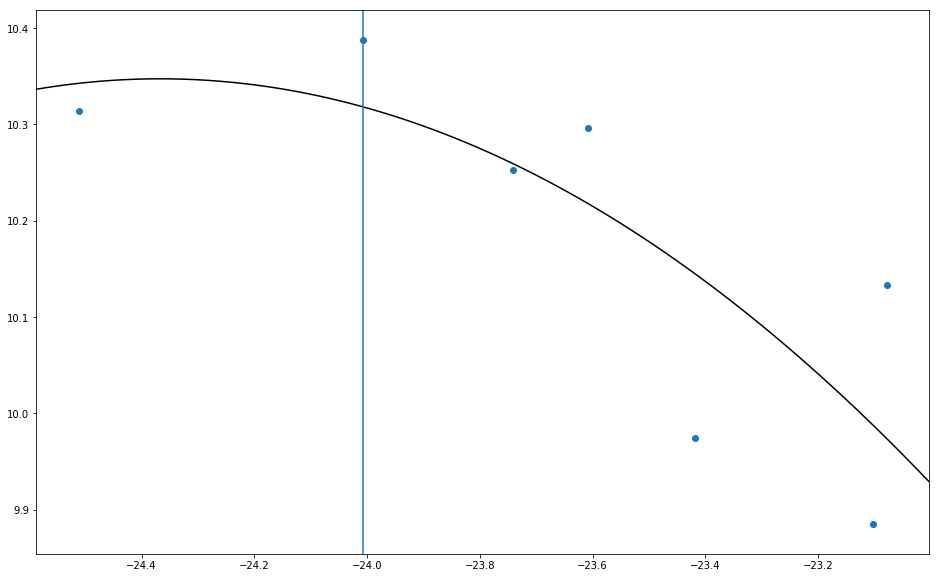

In [922]:
x = target_hosts['K_abs']
y = np.log10(target_hosts['stellar_mass'])

KtolMs = modeling.models.Polynomial1D(2)
KtolMs = modeling.fitting.LinearLSQFitter()(KtoMs, x, y)

plt.scatter(x, y)
xs = np.linspace(plt.xlim()[0], plt.xlim()[-1], 100)
plt.plot(xs, KtolMs(xs), c='k')
plt.axvline(target_hosts['K_abs'][-1])
plt.xlim(xs[0], xs[-1])

85746 1 9.885361220031513
13927 0 10.296665190261532
140594 2 10.313867220369154
147606 7 10.38738982633873
165082 10 10.252853030979892
144953 3 10.133538908370218
165707 2 9.974511692737329


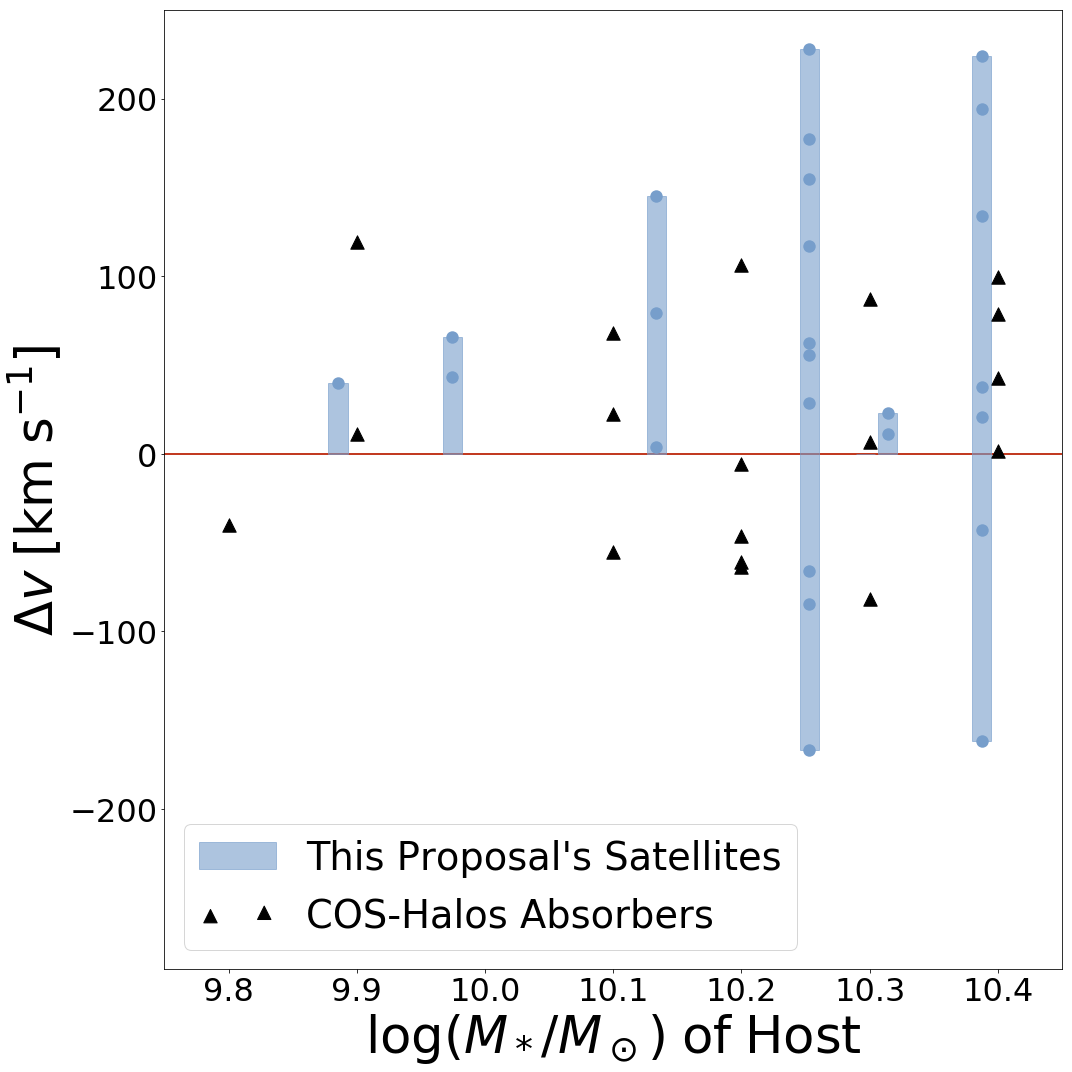

In [923]:
fontscale = 1.6

plt.figure(figsize=(15, 15))


host_lms = []
host_vs = []
satlabstr = 'This Proposal\'s Satellites'
satxys = []
satxs = []
satys = []

hosts_pgc_done = []
for qso in qso_selection: 
    host = target_hosts[target_hosts['PGC']==qso['SAGA_PGC']]
    if host['PGC'][0] in hosts_pgc_done:
        continue
    else:
        hosts_pgc_done.append(host['PGC'][0])
    sats = allsats[allsats['HOST_PGC']==qso['SAGA_PGC']]
    dist = host['distance'][0]*u.Mpc
    
    lsm = np.log10(host['stellar_mass'][0])
    
    host_lms.append(lsm)
    host_vs.append(0)
    
    dv = (np.array(sats['SPEC_Z'])*cnst.c - np.array(host['vhelio'])*u.km/u.s).to(u.km/u.s)
    dvspan = np.append(dv.value, 0)
    
    print(qso['SAGA_NSAID'], len(dv), lsm)
    
    satxs.extend([lsm]*len(sats))
    satys.extend(dv.value)
    satxys.append((satxs[-1], satys[-1]))
    
    width = .015
    height = np.ptp(dvspan)
    lowerx = lsm-width/2
    lowery = np.min(dvspan)
    plt.gca().add_patch(plt.Rectangle((lowerx, lowery), width, height, color=satcolor, alpha=.6, label=satlabstr, zorder=1))
    
    #plt.plot(satxys[-1][0], satxys[-1][1], '-o', c=satcolor, mec=satcolor, mew=0, label=satlabstr, ms=12)
    satlabstr = None
    
# add the missing one - only relevant if the "plus 3" option is chosen
#lMs_unk = KtolMs(target_hosts[-1]['K_abs'])
#plt.axvline(lMs_unk, lw=12, color=satcolor, alpha=.4) 
#plt.text(lMs_unk, 0, '?', color=satcolor,fontsize=48, ha='center')
#plt.text(lMs_unk, 0, '?', color=satcolor,
#         fontsize=48, ha='center', va='center')

plt.scatter(satxs, satys, color=satcolor, lw=0, s=155)
    
#plt.scatter(host_lms, [0]*len(host_lms), c=hostcolor, marker='s', s=200, lw=0, label='This proposal\'s hosts')
plt.axhline(0, c=hostcolor, lw=2, zorder=0)

plt.scatter(cos_halos_tab_good['mstar'], cos_halos_tab_good['v'], 
            color='k', label='COS-Halos Absorbers', marker='^', s=180,zorder=2)

#lmsmin, lmsmax = plt.xlim(9.5,11.2)
lmsmin, lmsmax = plt.xlim(9.75,10.45)

msrng = np.logspace(lmsmin, 11.5, 25)
mhrng = abundance_matching_ms_to_mh(msrng)

resc = 150*u.kpc
vesc = ((2*cnst.G*(mhrng/2)*u.Msun/(resc))**0.5).to(u.km/u.s)
#plt.plot(np.log10(msrng), vesc,c='k', ls=':', label=r'$v_{\rm esc}$')
#plt.plot(np.log10(msrng), -vesc,c='k', ls=':')

plt.ylim(-290,250)

plt.xlabel(r'$\log(M_*/M_\odot) {\rm \; of \; Host}$', fontsize=32*fontscale)
plt.ylabel(r'$\Delta v \; [{\rm km \; s^{-1}}]$', fontsize=32*fontscale)
plt.xticks(fontsize=20*fontscale)
plt.yticks(fontsize=20*fontscale)

h, l = plt.gca().get_legend_handles_labels()
#h.append(h.pop(1))
#l.append(l.pop(1))
plt.legend(h, l, loc='lower left', scatterpoints=2, fontsize=24*fontscale)

# plt.twiny()
# plt.xlim(np.log10(mhrng[0]), np.log10(mhrng[-1]))
# plt.xticks(fontsize=20)
# plt.xlabel(r'$\log(M_{\rm halo}/M_\odot) {\rm \; of \; Host}$', fontsize=32)

plt.tight_layout()
plt.savefig('horn.pdf')

# Extra Bits 

## Check DES hosts 

In [222]:
tab_saga_hosts

SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,SAGA_nameDISCARD,NSAIDDISCARD,RADISCARD,DecDISCARD,NSA1IDDISCARD,NGCDISCARD,UGCDISCARD,vhelioDISCARD,distanceDISCARD,rDISCARD,iDISCARD,zDISCARD,IDISCARD,KDISCARD,K_errDISCARD,flagDISCARD,K_absDISCARD,r_absDISCARD,bDISCARD,dist_to_groupDISCARD,brightest_K_nearbyDISCARD,SDSS_FRACGOODDISCARD,RA_subDISCARD,Dec_subDISCARD,othernameDISCARD,vhelio_subDISCARD,vhelio_errDISCARD,distance_subDISCARD,dist_2MASS_NSADISCARD,uDISCARD,u_errDISCARD,A_uDISCARD,M_uDISCARD,gDISCARD,g_errDISCARD,A_gDISCARD,M_gDISCARD,r_subDISCARD,r_errDISCARD,A_rDISCARD,M_rDISCARD,i_subDISCARD,i_errDISCARD,A_iDISCARD,M_iDISCARD,z_subDISCARD,z_errDISCARD,A_zDISCARD,M_zDISCARD,JDISCARD,J_errDISCARD,A_JDISCARD,M_JDISCARD,HDISCARD,H_errDISCARD,A_HDISCARD,M_HDISCARD,K_subDISCARD,K_err_subDISCARD,A_KDISCARD,M_KDISCARD,stellar_massDISCARD,sersic_nDISCARD,MK_compiledDISCARD,des_dr1DISCARD,decals_dr5DISCARD,decals_dr6DISCARD,coord,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_uvqs_fuv_lt_19,n_uvqs_fuv_lt_18.5,n_uvqs_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,
str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,str11,int64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64,int64,int64
Bandamanna,126115,0.995575,20.7524,279,613769,7817,19,2309.0,32.4741,12.5605,12.1093,11.7516,10.65,8.4,0.015,0,-24.1577,-19.9972,-40.7605,14.1617,--,0.975929,0.995575,20.7524,NGC_7817,2309.0,-1,32.4741,0.610269,14.2853,0.00949019,0.246425,-18.5575,12.8044,0.000935407,0.192013,-19.9616,11.9377,0.000573401,0.132833,-20.7677,11.4279,0.000569579,0.0987095,-21.2398,11.0222,0.00146553,0.0734218,-21.6198,9.489,0.006,0.0412162,-23.1108,8.734,0.007,0.0261016,-23.8533,8.421,0.008,0.0175561,-24.1403,12700000000,0.60785,-24.1577,0.0,0.0,0.0,--,126115,0.995575,20.7524,613769,7817,19,2309.0,32.4741,--,--,--,10.65,8.4,0.015,0,-24.1577,--,-40.7605,14.1617,--,0.975929,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-24.1577,0.0,0.0,0.0,"0.995575,20.7524",0,0,0,0,0,0
--,-1,8.56455,-27.8037,2052,-1,150,-1,1583.0,22.9306,--,--,--,10.29,8.506,0.02,48,-23.2961,--,-86.13,7.30434,12.136,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.2961,1.0,0.0,0.0,--,-1,8.56455,-27.8037,-1,150,-1,1583.0,22.9306,--,--,--,--,8.506,0.02,48,-23.2961,--,-86.13,7.30434,--,0.0,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,-23.29

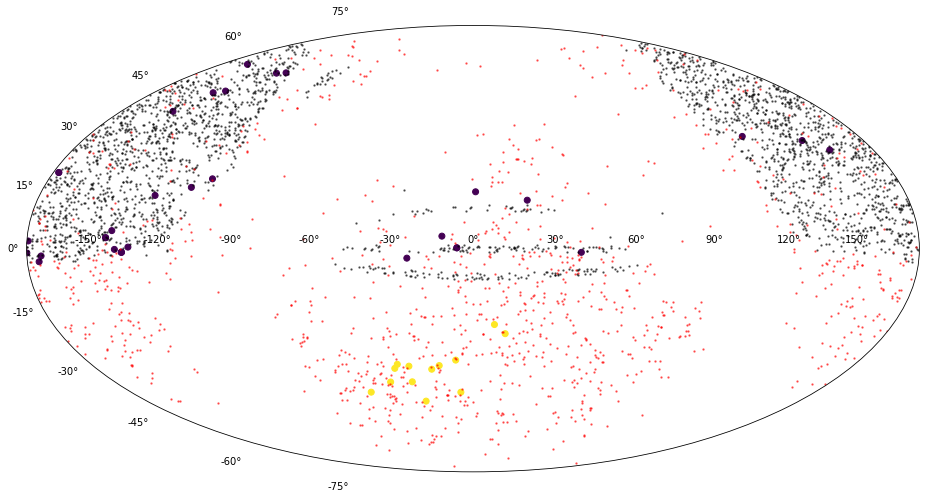

In [234]:
ax = plt.subplot(projection='hammer')

ax.scatter(tab_saga_hosts['coord'].ra.wrap_at(180*u.deg).rad, tab_saga_hosts['coord'].dec.rad, 
           c=tab_saga_hosts['NSAID']==-1)

ax.scatter(tab_qso19['coord'].ra.wrap_at(180*u.deg).rad, tab_qso19['coord'].dec.rad, alpha=.5, c='k', s=2)
ax.scatter(uvqs_good_tab['coord'].ra.wrap_at(180*u.deg).rad, uvqs_good_tab['coord'].dec.rad, alpha=.5, c='r', s=2)



In [549]:
target_hosts

SAGA_name,NSAID,RA,Dec,PGC,NSA1ID,NGC,UGC,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,RA_sub,Dec_sub,othername,vhelio_sub,vhelio_err,distance_sub,dist_2MASS_NSA,u,u_err,A_u,M_u,g,g_err,A_g,M_g,r_sub,r_err,A_r,M_r,i_sub,i_err,A_i,M_i,z_sub,z_err,A_z,M_z,J,J_err,A_J,M_J,H,H_err,A_H,M_H,K_sub,K_err_sub,A_K,M_K,stellar_mass,sersic_n,MK_compiled,des_dr1,decals_dr5,decals_dr6,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_combined_fuv_lt_19,n_combined_fuv_lt_18.5,n_combined_fuv_lt_18,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
str11,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,str16,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,object
MobyDick,85746,149.588,32.3699,28805,413265,3067,5351,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,--,0.978734,149.588,32.3699,09582107+3222116,1451.33,-1,25.1343,0.401621,13.8392,0.00354317,0.0627641,-18.2411,12.514,0.000537367,0.0489054,-19.5442,11.7926,0.00051166,0.0338325,-20.2479,11.4313,0.000435475,0.0251412,-20.5994,11.1085,0.00110246,0.0187004,-20.9154,9.886,0.011,0.0104977,-22.1253,9.156,0.015,0.00664805,-22.8525,8.904,0.015,0.00447152,-23.0925,7680000000,0.932093,-23.1023,0.0,0.8620689655,0.7513061651,3,2,2,3,2,2,"149.588,32.3699"
Alice,140594,180.098,-1.10008,37845,627617,4030,6993,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,180.098,-1.10008,g1200236-010600,1465.0,-1,23.2487,0.508479,12.5696,0.00122745,0.112339,-19.3871,11.1341,0.00028931,0.0875336,-20.795,10.3932,0.000242571,0.0605553,-21.5041,9.98552,0.000254046,0.0449991,-21.896,9.68725,0.000379465,0.0334711,-22.1818,8.271,0.009,0.0187894,-23.5789,7.604,0.012,0.0118991,-24.24,7.33,0.015,0.00800337,-24.5004,20600000000,1.7545,-24.511,0.0,0.9718162839,0.0,1,1,1,1,1,1,"180.098,-1.10008"
Sopranos,13927,180.676,1.9768,38031,67580,4045,7021,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,180.676,1.9768,12024224+0158364,1961.14,-1,29.5168,0.274163,13.8217,0.00447421,0.0945623,-18.6446,12.1464,0.000997383,0.0736823,-20.2948,11.276,0.000807301,0.050973,-21.1343,10.8059,0.000719835,0.0378784,-21.5905,10.4349,0.00130936,0.0281746,-21.9503,9.742,0.017,0.0158161,-22.624,9.07,0.018,0.0100161,-23.2915,8.751,0.026,0.00673692,-23.5937,19800000000,3.12889,-23.6073,0.0,0.9801462905,0.0,1,1,1,1,1,1,"180.676,1.9768"
mmt18_4,144953,215.579,50.5014,51340,631628,5602,9210,2230.0,34.1543,12.73,12.3754,12.1022,11.36,9.589,0.034,0,-23.0782,-19.9373,60.9291,10.6058,11.408,0.98866,215.579,50.5014,NGC_5602,2230.0,-1,34.1543,0.166161,14.6887,0.0277383,0.0845753,-18.0876,12.8071,0.00155138,0.0659005,-19.9454,11.9989,0.00132423,0.0455897,-20.7215,11.6129,0.00132934,0.033878,-21.0954,11.3127,0.00194438,0.025199,-21.3843,10.476,0.019,0.0141458,-22.2028,9.871,0.024,0.00895832,-22.8044,9.596,0.032,0.00602542,-23.0615,13600000000,5.17427,-23.0782,0.0,0.0,1.0,1,1,0,1,1,0,"215.579,50.5014"
Dune,165536,221.546,-0.222942,52735,683144,5750,9512,1659.36,25.3928,11.856,11.4773,11.2276,11.13,8.424,0.028,0,-23.5996,-20.1676,51.1661,3.0291,11.635,0.983643,221.546,-0.222942,14461112-0013226,1659.36,-1,25.3928,0.536969,13.6947,0.00266662,0.189113,-18.5338,11.9889,0.000519747,0.147356,-20.1962,11.1872,0.000433385,0.10194,-20.944,10.7607,0.000439995,0.0757523,-21.344,10.4701,0.000769938,0.0563458,-21.6137,9.389,0.014,0.0316304,-22.6648,8.64,0.014,0.0200311,-23.4031,8.44

In [550]:
host_row_to_catalog[6]

OBJID,RA,DEC,REMOVE,is_galaxy,morphology_info,radius,radius_err,u_mag,g_mag,r_mag,i_mag,z_mag,y_mag,u_err,g_err,r_err,i_err,z_err,y_err,survey,OBJID_sdss,RA_sdss,DEC_sdss,REMOVE_sdss,is_galaxy_sdss,morphology_info_sdss,radius_sdss,radius_err_sdss,u_mag_sdss,g_mag_sdss,r_mag_sdss,i_mag_sdss,z_mag_sdss,y_mag_sdss,u_err_sdss,g_err_sdss,r_err_sdss,i_err_sdss,z_err_sdss,y_err_sdss,HOST_NSAID,HOST_NSA1ID,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_MR,HOST_MG,HOST_SAGA_NAME,HOST_NGC,HOST_PGC,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SPEC_REPEAT,SPEC_REPEAT_ALL,SPEC_Z,SPEC_Z_ERR,ZQUALITY,SPECOBJID,MASKNAME,TELNAME,EM_ABS,HELIO_CORR,RA_spec,DEC_spec,SATS,sb_r,log_sm,ug,ug_err,gr,gr_err,ri,ri_err,iz,iz_err,zy,zy_err,rz,rz_err,coord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
int64,float64,float64,int64,bool,int32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,str6,int64,float64,float64,int64,bool,int32,float32,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float64,int32,int32,float32,float32,float32,float32,float32,float32,float32,str48,int32,int32,float32,float32,int32,str48,str48,float32,float32,int16,str48,str48,str6,int16,bool,float64,float64,int16,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,object
1237662301378642822,254.6327823637886,23.640518451788427,64,False,6,1.5048074,9999.0,21.777536,25.79088,24.778818,23.562538,23.366959,99.0,0.17055617,0.32616657,0.4947321,0.5179411,0.39861575,99.0,sdss,1237662301378642822,254.6327823637886,23.640518451788427,64,False,6,1.5048074,9999.0,21.777536,25.79088,24.778818,23.562538,23.366959,99.0,0.17055617,0.32616657,0.4947321,0.5179411,0.39861575,99.0,147606,633944,255.21,23.011,39.4152,2790.0,-23.9846,-21.3108,-20.4712,,6278,59426,49.37646,566.10223,-1,,,nan,nan,-1,,,,-1,False,nan,nan,-1,27.661673,nan,-4.013344,0.36806798,1.0120621,0.5925745,1.21628,0.71625614,0.19557953,0.65357286,-75.63304138183594,99.00080249429449,1.4118595,0.635338,"254.6327823637886,23.640518451788427"
1237662301378642829,254.63701755549013,23.62166563278334,0,True,3,0.7447483,0.05473604,21.61217,20.942606,20.3317,19.978497,20.048435,99.0,0.17457242,0.040588412,0.033061173,0.036548443,0.12923174,99.0,sdss,1237662301378642829,254.63701755549013,23.62166563278334,0,True,3,0.7447483,0.05473604,21.61217,20.942606,20.3317,19.978497,20.048435,99.0,0.17457242,0.040588412,0.033061173,0.036548443,0.12923174,99.0,147606,633944,255.21,23.011,39.4152,2790.0,-23.9846,-21.3108,-20.4712,,6278,59426,48.36547,554.51196,-1,,,nan,nan,-1,,,,-1,False,nan,nan,-1,21.687197,nan,0.6695633,0.17922877,0.6109066,0.052349407,0.35320282,0.049283158,-0.06993866,0.13430052,-78.95156478881836,99.00008434764895,0.28326416,0.13339372,"254.63701755549013,23.62166563278334"
1237662301378642834,254.66478995192415,23.63301140186299,0,False,6,0.54122293,0.035008967,21.763264,20.67333,20.362928,20.196764,20.23462,99.0,0.15294217,0.027142365,0.026378749,0.032282244,0.10902259,99.0,sdss,1237662301378642834,254.66478995192415,23.63301140186299,0,False,6,0.54122293,0.035008967,21.763264,20.67333,20.362928,20.196764,20.23462,99.0,0.15294217,0.027142365,0.026378749,0.032282244,0.10902259,99.0,147606,633944,255.21,23.011,39.4152,2790.0,-23.9846,-21.3108,-20.4712,,6278,59426,47.90833,549.2712,-1,,,nan,nan,-1,,,,-1,False,nan,nan,-1,21.025259,nan,1.0899334,0.15533195,0.31040192,0.037848994,0.1661644,0.04168911,-0.03785515,0.113701664,-78.765380859375,99.00006002990399,0.12830925,0.11216846,"254.66478995192415,23.63301140186299"
1237662301378642835,254.66373769566528,23.631701716529005,0,True,3,1.1844857,0.15122731,22.987707,22.013477,21.341394,21.050661,20.910158,99.0,0.7228876,0.13105099,0.10392458,0.14179751,0.38038903,99.0,sdss,1237662301378642835,254.66373769566528,23.631701716529005,0,True,3,1.1844857,0.15122731,22.987707,22.013477,21.341394,2

#### Check if any targets have funky FUV-NUV colors 

In [894]:
qso_selection

OBJECT_NAME,RA,DEC,FUV_MAG,NUV_MAG,Z,r,hsla_match_idx,qso_to_host,qso_to_host_phys,SAGA_name,SAGA_NSAID,SAGA_PGC,coord
,deg,deg,,,,,,deg,kpc,,,,"deg,deg"
str80,float64,float64,float64,float64,float64,float64,int64,float64,float64,str8,int64,int64,object
FBQS J095820.9+322402,149.58726501464844,32.4006233215332,17.137916564941406,16.465614318847656,0.5306000113487244,16.020999908447266,--,0.030729590254148807,13.480342651564731,MobyDick,85746,28805,"149.58726501464844,32.4006233215332"
SDSS J095914.85+320357.2,149.81187438964844,32.06591033935547,17.528425216674805,16.99718475341797,0.5638999938964844,16.992000579833984,35,0.3581665444819515,157.11917100136895,MobyDick,85746,28805,"149.81187438964844,32.06591033935547"
SDSS J120233.08+022559.7,180.6378631591797,2.4332659244537354,17.655315399169922,17.676992416381836,0.27300000190734863,17.270000457763672,--,0.4580539247957969,235.97350803693132,Sopranos,13927,38031,"180.6378631591797,2.4332659244537354"
2MASX J12022678-0129155,180.6114959716797,-1.487576961517334,17.832124710083008,17.52016258239746,0.15039999783039093,17.131000518798828,--,0.6431924808082065,260.9858728800687,Alice,140594,37845,"180.6114959716797,-1.487576961517334"
UVQSJ170043.71+223700.2,255.182125,22.616722222222222,17.92194366455078,17.54443359375,0.44513264298439026,-1.0,--,0.39511411036462246,271.8088804304997,mmt18_8,147606,59426,"255.182125,22.616722222222222"
SDSS J142940.73+032125.8,217.41976928710938,3.3571879863739014,18.200599670410156,18.245100021362305,0.2531000077724457,18.152000427246094,43,0.12389057890187925,53.871288948931536,mmt18_5,165082,51787,"217.41976928710938,3.3571879863739014"
SBS 1421+511,215.80909729003906,50.927024841308594,18.38580894470215,18.708524703979492,0.2757999897003174,17.672000885009766,--,0.44986998210657064,268.16974060635937,mmt18_4,144953,51340,"215.80909729003906,50.927024841308594"
TON 1129,149.0967254638672,32.60601806640625,18.674198150634766,18.040430068969727,0.5263000130653381,17.56999969482422,--,0.4769400366704873,209.2222859268354,MobyDick,85746,28805,"149.0967254638672,32.60601806640625"


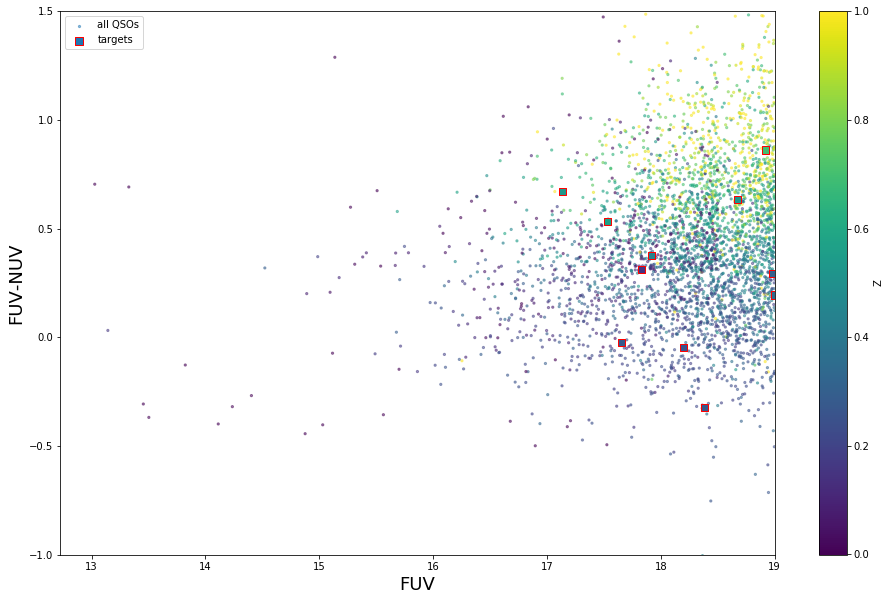

In [905]:
vmin = np.min(tab_qsos_combined['Z'])
vmax = 1#np.max(tab_qsos_combined['Z'])

fa = tab_qsos_combined['FUV_MAG']
na = tab_qsos_combined['NUV_MAG']
sc1 = plt.scatter(fa, fa - na, alpha=.5,s=5, label='all QSOs', c=tab_qsos_combined['Z'],
                  vmin=vmin, vmax=vmax)

f = qso_selection['FUV_MAG']
n = qso_selection['NUV_MAG']
sc2 = plt.scatter(f, f - n, marker='s', c=qso_selection['Z'],s=50, label='targets', 
                  vmin=vmin, vmax=vmax, 
                  linewidths=1, edgecolors='r')

plt.ylim(-1,1.5)
plt.xlim(plt.xlim()[0], 19)

plt.legend(loc=0)

plt.colorbar(sc2).set_label('Z')

plt.xlabel('FUV', fontsize=18)
plt.ylabel('FUV-NUV', fontsize=18)

plt.savefig('/Users/erik/Desktop/nuvfuv_lls_danger.pdf')

The highest target in that diagram might be a bit fishy...:

In [903]:
nuv_brightest = qso_selection[np.argmax(f-n)]
print('http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra={}&dec={}'.format(nuv_brightest['RA'], nuv_brightest['DEC']))
nuv_brightest

http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=221.69322204589844&dec=-0.5288329720497131


OBJECT_NAME,RA,DEC,FUV_MAG,NUV_MAG,Z,r,hsla_match_idx,qso_to_host,qso_to_host_phys,SAGA_name,SAGA_NSAID,SAGA_PGC,coord
,deg,deg,,,,,,deg,kpc,,,,"deg,deg"
str80,float64,float64,float64,float64,float64,float64,int64,float64,float64,str8,int64,int64,object
LBQS 1444-0019,221.69322204589844,-0.5288329720497131,18.922800064086914,18.06130027770996,0.6976000070571899,17.888999938964844,--,0.33947405386486856,150.45081554412903,Dune,165536,52735,"221.69322204589844,-0.5288329720497131"


Probably a LLS!

In [931]:
#CIV for each host
(1+target_hosts['vhelio']/3e5)*1549

1556.4937005666666
1556.5642833333334
1559.1260195333332
1560.5142333333336
1557.3749266666664
1560.0630096333334
1563.4057
